TODO:
-	get the unit renaming in the columns working with regex in `ac_representation_tool`

-	figure out why the sym and symbolic all-pass filter diverge from each other

-	create a table of low-high pass vs rc & rl

-	look into ngspice internals and really verify that there are no 
equivalencies to dc internals with .ac sims

Most likely will do this in another section further down the road

-	add filter design tool and filter circuit generation tool; see isbn 978-0-387-92766-4 and things like cauer network tf implimentation

-	discuss L->C passive conversion


In [1]:
from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym


from IPython.display import YouTubeVideo, display

import traceback
import warnings

In [2]:
from DC_1_Codes import get_skidl_spice_ref
#from AC_2_Codes import 

sym.init_printing()

#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# Basic Passive Filters

In this section, we will construct and look at the basic passive analog filters constructed of RLC elements only. For now, we will just develop an ac equivalent tool to `dc_ease` that was in the last chapter. As well as some basic data manipulation, plotting tool, and classes for the RLC primitive filters. For advanced tools filter analysis will be developed later in this chapter in section asdlkjfaljdfkj where then we can compare not only the SPICE simulation data but also the SPICE generated Pole-Zero Transfer function and the theoretical transfer function to each other in greater detail.


## The RC Low Pass Filter¶

The RC filter is a first-order single-pole filter. Where the pole is realized physically by a shunt capacitor. For more technical details about an RC low pass filter consult the YT video by ALL ABOUT ELECTRONICS "RC Low Pass Filter Explained" that serves as the example source below


### The low pass RC filter from ALL ABOUT ELECTRONICS "RC Low Pass Filter Explained" @~ 8:35min

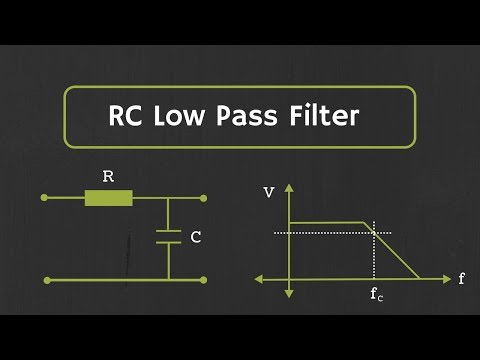

In [3]:
YouTubeVideo('_2L0l-E1Wx0', width=500, height=400, start=515)

### RC Low Pass Filter Subcircuit container class

The class below is the first in a series of classes developed in this section to create and store information about the filter primitive under test. For each of these primitives we will create a class that does three things:

-	stores the filter element values in the class initiation method

-	generates the filter and its elements inside a SKiDl subcircuit to then included in the circuit under design

-	provides a schematic representation method of the filter being constructed by this class via lcapy

-	provides the transfer function and two-port representation of the filter in sympy via its own methods by using the lcapy schematic 

We see how this is done with the RC Low Pass filter first below


In [4]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rc_lowpass filter class
#class with lcapy and skidl subcircuit to create an RC lowpass filter

class rc_lowpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    lowpass RC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RC_Lowpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RC lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Cref={}
            Rref={}
            
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, self.c['p']
        self.c['p', 'n']+=term_2, term_3
        
        if return_elements:
            return self.c, self.r
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract simply variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        self.with_values=with_values
        
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add('R 0_1 2_1; right')
        self.schematic.add('C 2_1 1_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)
        
            
        
        


In the method for the subcircuit `SKiDl` above we referenced a port-terminal convention from a library **scikit-rf**. This is the main python library for S-parameter analysis and primitive rf circuit design in the Python scientific ecosystem. Where we will interact with it at length in the following sections but for now let's just get in the habit of using their port-terminal convention since we are coding all this up in python

Below we instantiate the filter to the values found in the reference example above and draw it

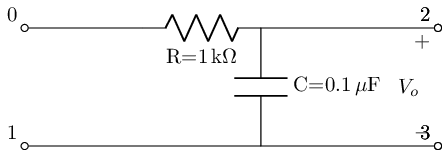

In [5]:
#instatate the rc_lowpass filter to 
lowpassF=rc_lowpass(C_value=.1@u_uF, R_value=1@u_kOhm)
lowpassF.lcapy_self()

Nest using `lcapy` we can use the circuit we created in `rc_lowpass.lcapy_self` to then extract the voltage transfer function coming from the Port 0 & 1 Terminals to the Port 2 & 3 Terminals. Where the method has been abstracted such that it can be called to just get the symbolic equation or get the symbolic equation with the values of this particular instance substituted into the symbolic expression.

In [6]:
#get this filters abstract transfer function
lowpassF.get_tf(with_values=False)

      1      
─────────────
    ⎛     1 ⎞
C⋅R⋅⎜s + ───⎟
    ⎝    C⋅R⎠

In [7]:
#get this filters transfer function
lowpassF.get_tf(with_values=True)

  10000  
─────────
s + 10000

and finally, we will now use the lowpass filter in its primary utilization as part of a circuit to be simulated with SPICE.

In [8]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
lowpassF.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)


.title 
C1 Out 0 0.1uF
R1 In Out 1kOhm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



### making ac_ease¶

In the last chapter, we developed a class `dc_ease` to make running the .dc SPICE simulation more automated. Here we will develop an analogies class `ac_ease` to automate the .ac simulation. There are some differences thou. For one with .dc simulation, we could sweep over any variable (I still need to fix pyspice to do that); whereas we learned in the last section that .ac simulation only allows us to sweep the operating frequency of all our sources simultaneously and observe the response of the circuit to each frequency in terms of Fourier transform terms. The second thing is that .dc simulations allowed us to access a plethora of circuit elements' internal parameters to record things such as current and power without having to add SPICE ammeter all over the place. While .ac does not have quite that support in ngspice (see typically chapter 31 "Model and Device Parameters" in the ngspice manual). So we are going to forgo do internal parameters in `ac_ease`.



Also, in the last section, we just used the "linear" sweep capability of an ac simulation. However, AC simulations are more commonly done via logarithm sweeps. This is akin to `np.logspace`, however, unlike NumPy's logspace, we till .ac what the starting and stop are and how many samples we want per decade. And then there is the less used " octave " sampling scheme where there is no numpy kin. Octave takes the starting frequency, say 1kHz, and then computes the doubles of it (think octaves in music) and then samples within that doubling. So 1kHz doubles to 2kHz and so on till the stop frequency is reached while getting n samples within each double via the "number_of_points" argument in the .ac simulation control.

In [9]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 ac_ease class
#class to perform .ac simulations with a bit more grace

class ac_ease():
    """
    Class to perform AC (.ac) SPICE simulation with some grace; 
    currently limited to what pyspice and ngspice support
    
    TODO:
        - independent current sources can have their AC current measured via 
        `@I<name>[acreal]` & `@I<name>[acrimag]` not shure if this is usefull
        also trying via the sensitivity 
        - do some serious testing with ngspice directly to verify that internal
        parameters are as limited as they appear to be with .ac
        
    """
    def __init__(self, circ_netlist_obj):
        """
        Class to perform AC (.ac) SPICE simulation with some grace
        
        Args:
            circ_netlist_obj (pyspice.Spice.Netlist.Circuit): the Netlist circuit produced 
                from SKiDl's `generate_netlist()`
        
        Returns: 
            creates a table to control the ac sweep `self.fsweep_DF`
            this table will still need to be filled out before a simulation can be run with `self.do_ac_sim`
            can be filled out manually or with the helper method `self.ac_sweep_setup`
        """
        self.circ_netlist_obj=circ_netlist_obj
        self._build_table()
        
        #dic of allowed AC sweep types
        self.allowed_steptypes_map={'linear':'lin', 'decade':'dec', 'octave': 'oct'}

    
    def _build_table(self):
        """
        protected method to create `self.fsweep_DF` dataframe that stores the controls for the ac simulation
        
        TODO:
            -when pyspice accepts more things to sweep add them below
        """
        self.fsweep_DF=pd.DataFrame(columns=['Start_freq', 'Stop_Freq', 'SamplingInc', 'StepType'])
        self.fsweep_DF.at[len(self.fsweep_DF)]=[.1@u_Hz, 120@u_GHz, 10, 'decade']

    def ac_sweep_setup(self, Start_freq, Stop_Freq, SamplingInc, StepType, display_table=False):
        """
        Helper method to create the `self.fsweep_DF` to control the ac simulation
        
        Args:
            Start_freq (Hertz): starting frequency in Hertz of the ac simulation, must be less than `Stop_Freq` and can
                only be zero if `StepType='linear'`
            
            Stop_Freq (Hertz): stoping  frequency in Hertz of the ac simulation, must be greater than `Start_freq` 
            
            SamplingInc (int): number of samples per StepType interval
            
            StepType (string): string control for the ac simulation Step type.
                must be 'linear' (self-explanatory), 'decade' (log base 10 sampling interval), 
                or 'octave' (starting frequency times 2**n to create sample space a double of the starting frequency
                so that samples are pulled from 2**(n-1) and 2**(n) times the starting frequency)
            
            display_table (bool; False): when true will display the generated `self.fsweep_DF` below
             this method call in a jupyter notebook like environment
            
        TODO:
            -add display action
        """
        #check for allowed step types
        assert StepType in self.allowed_steptypes_map.keys(),  f"{StepType} is not allowed"
        #force start to non zero if sweep not linear
        if StepType != 'linear':
            if float(Start_freq)==0:
                warnings.warn('"linear" is only sweep type that can start at 0Hz,\n setting starting frequancy to 1e-1Hz')
                Start_freq=1e-1@u_Hz
                
                
        #check that stop frequency is greater than start
        assert Stop_Freq>Start_freq, 'Stop frequency must be greater then starting frequency'
        
        self.fsweep_DF.at[0]=[Start_freq, Stop_Freq, SamplingInc, StepType]
        
        if display_table:
            display(self.fsweep_DF)
    
    def _make_sim_control(self):
        """
        Internal method to extract the row information to the .ac pyspice call arguments
        Will raise a warning if the simulation start frequency is 0Hz for non-linear frequency sampling and 
        then set the start frequency to .1Hz
        
        Args:
            NONE
            
        Returns:
            `self.ac_control` what is feed into the .ac to do the simulation over a frequency
            
        """
        
        #check the control table struct
        assert (self.fsweep_DF.columns==['Start_freq', 'Stop_Freq', 'SamplingInc', 'StepType']).all(), 'Contorl Table Column structer has been altered'
        
        #will probably change this down the road
        assert len(self.fsweep_DF)==1, 'there should only be one entry in the control table'
        
        #check the sweep type
        self.fsweep_DF['StepType'][0] in self.allowed_steptypes_map.keys(), f"{self.fsweep_DF['StepType'][0]} is not allowed"
        
        #check that stop frequency is greater than start
        assert self.fsweep_DF.at[0, 'Stop_Freq']>self.fsweep_DF.at[0, 'Start_freq'], 'Stop freqauncy must be grater then starting freauncy'
        
        #force start to non zero if sweep not linear
        if self.fsweep_DF['StepType'][0] != 'linear':
            if float(self.fsweep_DF['Start_freq'][0])==0:
                warnings.warn('"linear" is only sweep type that can start at 0Hz,\n setting starting frequancy to 1e-1Hz')
                self.fsweep_DF.at[0, 'Start_freq']=1e-1@u_Hz
        
        self.ac_control={
            'start_frequency':self.fsweep_DF.at[0, 'Start_freq'], 
            'stop_frequency':self.fsweep_DF.at[0, 'Stop_Freq'], 
            'number_of_points':self.fsweep_DF.at[0, 'SamplingInc'],
            'variation': self.allowed_steptypes_map[self.fsweep_DF.at[0, 'StepType']]
        }
        
        
        
    
    def do_ac_sim(self):
        """
        Does a standard Branch and Node .ac simulation for the single filled out row in `self.fsweep_DF`
        
        Args:
            None
        
        Returns: 
            raw results are stored in `self.ac_vals`, processed results are automatically stored in 
            `self.ac_resultsNB_DF` via `self.record_ac_nodebranch`
        """
        self._make_sim_control()
        self.sim=self.circ_netlist_obj.simulator()
        self.ac_vals=self.sim.ac(**self.ac_control)
        
        self.record_ac_nodebranch()

    
    def record_ac_nodebranch(self):
        """ 
        Helper method to put .ac node branch results into a dataframe where the index is the 
        sweep frequency used in the simulation
        
        Args:
            None
        
        Returns:
            `self.ac_resultsNB_DF` which is a pandas dataframe with the index being the sweep frequency
            and the columns being the node voltages and branch currents from any available voltage sources  
            
        TODO:
            look into getting the current in any current sources
            
        """
        self.ac_resultsNB_DF=pd.DataFrame(index=self.ac_vals.frequency.as_ndarray())
        self.ac_resultsNB_DF.index.name='freq[Hz]'
        
        #get the node voltages
        for n in self.circ_netlist_obj.node_names:
            if n=='0':
                continue
            self.ac_resultsNB_DF[n+'_[V]']=self.ac_vals[n].as_ndarray()
        
        #get the current from any voltage source
        for cm in self.circ_netlist_obj.element_names:
            if 'V'==cm[0]:
                self.ac_resultsNB_DF[cm+'_[A]']=-self.ac_vals[cm].as_ndarray()
                

In [10]:
#instainte the simulation from the circuit
ac_sweep=ac_ease(circ)
#setup the simulation parameter with the helper method
ac_sweep.ac_sweep_setup(0, 100@u_MHz, 10, 'decade', True)

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: "linear" is only sweep type that can start at 0Hz,
 setting starting frequancy to 1e-1Hz


,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,100 MHz,10,decade


In [11]:
ac_sweep.do_ac_sim()
ac_sweep.ac_resultsNB_DF

,Out_[V],In_[V],V1_[A]
freq[Hz],,,
1.000000e-01,1.000000-0.000063j,1.000000+0.000000j,3.947842e-12+6.283185e-08j
1.258925e-01,1.000000-0.000079j,1.000000+0.000000j,6.256907e-12+7.910062e-08j
1.584893e-01,1.000000-0.000100j,1.000000+0.000000j,9.916529e-12+9.958178e-08j
1.995262e-01,1.000000-0.000125j,1.000000+0.000000j,1.571664e-11+1.253660e-07j
2.511886e-01,1.000000-0.000158j,1.000000+0.000000j,2.490920e-11+1.578265e-07j
...,...,...,...
3.981072e+07,0.000000-0.000040j,1.000000+0.000000j,1.000000e-03+3.997791e-08j
5.011872e+07,0.000000-0.000032j,1.000000+0.000000j,1.000000e-03+3.175559e-08j
6.309574e+07,0.000000-0.000025j,1.000000+0.000000j,1.000000e-03+2.522436e-08j


### making a basic ac data conversion tool

As we learned in the last section since the returns of an AC simulation are complex values we have to represent the values in order to just plot the values. The following class has methods that will allow us to pass in the raw results of the AC simulation and then perform reinterpretation of the values as needed


In [12]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 ac_representation_tool class
#class that converts dataframe of raw ac complex data to veries complex
#repsentations 

class ac_representation_tool:
    """
    Class to take a dataframe with AC simulation complex value data and
    represent it in various ways. raw data should come from `ac_ease.ac_resultsNB_DF`
    
    TODO:
        -get the unit renaming in the columns working with regex
    """
    
    def __init__(self, ac_sim_raw_DF):
        """
        pull in the data
        Args:
            ac_sim_raw_DF (pandas dataframe): pandas dataframe of raw data from AC simulation 
                preferbyly from `ac_ease.ac_resultsNB_DF`, index must be the simulation
                frequency and columns must be the complex data
        
        Returns: 
            None
        
        TODO:
            broaden complex assertin to include np.complex128
        """
        #write asserts for ac_sim_DF
        assert repr(type(ac_sim_raw_DF))=="<class 'pandas.core.frame.DataFrame'>", '`ac_sim_raw_DF` must be a dataframe'
        #check that all columns from raw data are complex
        assert (ac_sim_raw_DF.dtypes==np.complex64).all() or (ac_sim_raw_DF.dtypes==np.complex128).all(), 'Raw data must be complex from AC sim'
        self.ac_sim_raw_DF=ac_sim_raw_DF
    
    def make_real_imag(self):
        """
        Method to create a real and image version of the raw data

        Args: None
        
        Returns:
            real values are stored in `self.ac_sim_real_DF`; and 
            imaginary values are stored in `self.ac_sim_imag_DF`
            
        """
        
        self.ac_sim_real_DF=self.ac_sim_raw_DF.apply(np.real, axis=0)
        
        self.ac_sim_imag_DF=self.ac_sim_raw_DF.apply(np.imag, axis=0)
        
    
    def make_mag_phase(self, mag='dB', char_res=50, deg=True, phase_unwrap=True):
        """
        Method to make generate the various magnitude and phase representation of the complex data
        
        Args:
            mag (string, "dB"): control statement to specify the representation of the generated 
                magnitude data; right now only 'dB' and 'abs' are supported
            
            char_res (float; 50; ohms): the characteristic impedance for magnitude representation calculations; not 
                implemented at the moment
            
            deg (bool; True): bool control statement to represent the phase data in degrees if True; else in radians
            
            phase_unwrap (bool; True): when True and `deg` is True will represent the degrees in phased unwrapped
        
        Returns:
            magnitude data is stored in `self.ac_sim_mag_DF` and phase data is stored in `self.ac_sim_phase_DF`
        
        TODO: 
            -complete all of the magnitude conversions
        """
        #deal with the cacophony of magnitudes
        mag_conversions={
            'dB': lambda x: 10*np.log10(np.abs(x)) if x.name in ['[W]', '[VAR]', '[VA]'] else 20*np.log10(np.abs(x)), 
            'abs': lambda x: np.abs(x)
        }
        
        #check the input
        assert mag in mag_conversions.keys(), f'{mag} is not a known magnitude repsentation'
         
        self.ac_sim_mag_DF=self.ac_sim_raw_DF.apply(mag_conversions[mag], axis=0)
        
        #redo the column name units
        #get down with the regex to really do this
        if mag in ['dB']:
            self.ac_sim_mag_DF.rename(columns={i:i+'[dB]' for i in self.ac_sim_mag_DF.columns}, inplace=True)
        
        #deal with the phase
        
        if (deg==True) and (phase_unwrap==True):
            #phase unwrapped lambda function
            angle_phase_unwrap= lambda x: np.rad2deg(np.unwrap(np.angle(x)))

            self.ac_sim_phase_DF=self.ac_sim_raw_DF.apply(angle_phase_unwrap, axis=0)
        
        else:
            self.ac_sim_phase_DF=self.ac_sim_raw_DF.apply(np.angle, axis=0, deg=deg)

        #realy need that stupid regex working
        
        if deg:
            self.ac_sim_phase_DF.rename(columns={i:i+'[deg]' for i in self.ac_sim_phase_DF.columns}, inplace=True)
        else:
            self.ac_sim_phase_DF.rename(columns={i:i+'[rads]' for i in self.ac_sim_phase_DF.columns}, inplace=True)


In [13]:
ac_rep_tool=ac_representation_tool(ac_sweep.ac_resultsNB_DF)
ac_rep_tool.make_real_imag()
ac_rep_tool.ac_sim_real_DF


,Out_[V],In_[V],V1_[A]
freq[Hz],,,
1.000000e-01,1.000000e+00,1.0,3.947842e-12
1.258925e-01,1.000000e+00,1.0,6.256907e-12
1.584893e-01,1.000000e+00,1.0,9.916529e-12
1.995262e-01,1.000000e+00,1.0,1.571664e-11
2.511886e-01,1.000000e+00,1.0,2.490920e-11
...,...,...,...
3.981072e+07,1.598234e-09,1.0,1.000000e-03
5.011872e+07,1.008417e-09,1.0,1.000000e-03
6.309574e+07,6.362683e-10,1.0,1.000000e-03


In [14]:
ac_rep_tool.make_mag_phase()
ac_rep_tool.ac_sim_mag_DF

,Out_[V][dB],In_[V][dB],V1_[A][dB]
freq[Hz],,,
1.000000e-01,0.000000,0.0,-144.036407
1.258925e-01,0.000000,0.0,-142.036407
1.584893e-01,0.000000,0.0,-140.036407
1.995262e-01,0.000000,0.0,-138.036407
2.511886e-01,0.000000,0.0,-136.036407
...,...,...,...
3.981072e+07,-87.963600,0.0,-60.000000
5.011872e+07,-89.963600,0.0,-60.000000
6.309574e+07,-91.963593,0.0,-60.000000


### Making a complex representation plotting templet¶

Here we are going to make a class the store plot templets for the 3+1 major representations of complex values:

-	Bode Plot with Magnitude and Phase on the same plot: The Bode plot is the most widely used plot of complex data that is parametric to the frequency which we use as the x-axis. This is one of two standard variations of the Bode plot where the Magnitude and Phase is plotted on the same graph using twin axis

-	Bode Plot with Magnitude and Phase on the separate plots: In this version of the Bode plot the x-axis is still the frequency and there are two subplots sharing the same x-axis with the top plot being the magnitude plot and the bottom being the phase

-	Nichols Plot: This is a parametric plot where the x-axis and the phase and the y-axis is the magnitude and direction is indicated by an arrow along the line showing the direction of frequency increase. This plot is used more in Feedback and Control system design.

-	Nyquist Plot: This is a parametric plot where the x-axis and the real part and the y-axis is the imaginary part and direction is indicated by an arrow along the line showing the direction of frequency increase. This plot is used more in Feedback and Control system design.

This class contains templets since an existing matplotlib axis can be passed through them to then include them in more advanced plots with additional information being able to be added to the axis. Or these plot methods can be called without any axis passed to them to then generate a basic plot



In [15]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 eecomplex_plot_templets class
#class that stores templets plots for most common complex rep plots

class eecomplex_plot_templets():
    """
    Class that stores basic/common Electrical Engineering Complex value
    representation plots that may be used stand-alone or as templets in other plots 
    with refinements
    """
    def __init__(self):
        pass
    
    def bode_plot_one_templet(self, freq_data, mag_data, phase_data, ax=None, title=''):
        """
        Templet plot to make a Bode plot with Magnitude and Phase all in one
        graph using a twinx. 
        
        Args:
            freq_data (numpy array or pandas series; Hz): the sampling frequency
            
            mag_data (numpy array or pandas seres; dB): the magnitude data in decibels
            
            phase_data (numpy array or pandas series; deg unwrapped): the phase data in degrees unwrapped
            
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a bode plot, and if an axis was passed to `ax` will be modified
            with how to plot the magnitude
            
        
        TODO:
            - figure out how to return the `ax_phase` generated internally
            - add x,y scale control
        """
        assert len(freq_data)==len(mag_data)==len(phase_data), 'freq_data, mag_data, phase_data, must all be the same length'
        
        if ax!=None:
            assert repr(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>", 'ax must be a matplotlib axis'

        ax_mag=ax or plt.gca()


        #fig, ax_mag=plt.subplots()

        ax_phase=ax_mag.twinx()

        ax_mag.semilogx(freq_data, mag_data, label='mag')
        ax_phase.semilogx(freq_data, phase_data, color='green', linestyle='--', label='phase')
        

        ax_mag.set_xlabel('frequancy [Hz]')
        ax_mag.set_ylabel('[dB]')
        ax_phase.set_ylabel('[deg]')
        ax_mag.grid()
        
        #make a single legend 
        handles, labels = [(a + b) for a, b in zip(ax_mag.get_legend_handles_labels(), ax_phase.get_legend_handles_labels())]
        ax_phase.legend(handles, labels)

        if title!='':
            title=' of '+title
        ax_mag.set_title(f'Bode Plot{title}')
        
        
        
    def bode_plot_two_templet(self, freq_data, mag_data, phase_data, 
                              axs=None, title=''):
        """
        Templet plot to make a Bode plot with Magnitude and Phase in two separate subplots
        with shared x-axis
        
        Args:
            freq_data (numpy array or pandas series; Hz): the sampling frequency
            
            mag_data (numpy array or pandas seres; dB): the magnitude data in decibels
            
            phase_data (numpy array or pandas series; deg unwrapped): the phase data in degrees unwrapped
            
            axs (list of matplotlib axis; None): If left None will create a new plot, else must 
                be a list of matplotlib subplots axis to be added to where the first entry
                will be the magnitude axis, and the second will be the phase axis
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a bode plot, and if an axis was passed to `ax` will be modified
            with how to plot the magnitude
            
        
        TODO:
            - add x,y scale control
        """
        
        assert len(freq_data)==len(mag_data)==len(phase_data), 'freq_data, mag_data, phase_data, must all be the same length'
        
       
        if axs==None:
            fig, [ax_mag, ax_phase]=plt.subplots(nrows=2, sharex=True)
        else:
            assert len(axs)==2, 'there should only be two elements in axs'
            
            for i, ax in enumerate(axs):
                assert repr(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>", f"element {i} in axs was not a matplotlib axis"
            ax_mag=axs[0]; ax_phase=axs[1]
            ax_mag.get_shared_x_axes().join(ax_mag, ax_phase)
        
        #fore the two axes to share x
        ax_mag.xaxis.set_tick_params(which='both', labelbottom=True)




        ax_mag.semilogx(freq_data, mag_data, label='mag')
        ax_phase.semilogx(freq_data, phase_data, color='green', linestyle='--', label='phase')



        ax_mag.set_ylabel('[dB]')
        ax_phase.set_ylabel('[deg]')
        ax_mag.grid()
        ax_phase.grid()
        
        #style the x-axis for both subplots so it's between the two
        ax_phase.set_xlabel('frequancy [Hz]')
        ax_phase.xaxis.set_label_position('top') 
        ax_phase.xaxis.set_ticks_position('top') 
        ax_phase.tick_params(labelbottom=False,labeltop=True)

        if title!='':
            title=' of '+title
        ax_mag.set_title(f'Bode Plot{title}');
        plt.tight_layout()
    
    
    def nichols_plot_templet(self, mag_data, phase_data, ax=None, title=''):
        
        """
        Templet plot to make a Nichols plot with magnitude in the y-axis and
        phase in the x-axis, with a counter arrow showing the parametric direction
        
        Args:
            
            mag_data (numpy array or pandas seres; dB): the magnitude data in decibels
            
            phase_data (numpy array or pandas series; deg unwrapped): the phase data in degrees unwrapped
            
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a Nichols plot, and if an axis was passed to `ax` will be modified
            with the Nichols plot
            
        
        TODO:
            - add x,y scale control
        """
        
        assert len(mag_data)==len(phase_data), 'mag_data and phase_data, must all be the same length'

        if ax!=None:
            assert repr(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>", 'ax must be a matplotlib axis'

        ax=ax or plt.gca()

        ax.plot(phase_data, mag_data)
        line=ax.get_lines()[0]
        eecomplex_plot_templets.add_arrow(line)

        
        #xlim
        xmin=phase_data.min()*1.1; xmax=phase_data.max()*1.1
        
        if -1*xmax<xmin:
            xmin=-1*xmax
        
        if -1*xmin>xmax:
            xmax=-1*xmin
            
        ax.set_xlim(xmin, xmax)
        

        ax.set_xlabel('[deg]'); ax.set_ylabel('[dB]')

        ax.grid()
        #ax.axhline(0, linestyle='--', linewidth=2.0, color='black')
        ax.axvline(0, linestyle='--', linewidth=2.0, color='black')
        if title!='':
            title=' of '+title
        ax.set_title(f'Nichols Plot{title}');
        

    def nyquist_plot_templet(self, real_data, imag_data, ax=None, title=''):
        """
        Templet plot to make a Nyquist plot with imaginary in the y-axis and
        real in the x-axis, with a counter arrow showing the parametric direction
        
        Args:
            
            real_data (numpy array or pandas series): the real data 
            
            imag_data (numpy array or pandas series): the imaginary data
            
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a Nyquist plot, and if an axis was passed to `ax` will be modified
            with the Nyquist plot
            
        
        TODO:
            - add x,y scale control
        """
        assert len(real_data)==len(imag_data), 'real_data and imag_data, must all be the same length'

        if ax!=None:
            assert repr(type(ax))=="<class 'matplotlib.axes._subplots.AxesSubplot'>", 'ax must be a matplotlib axis'

        ax=ax or plt.gca()

        ax.plot(real_data, imag_data)
        line=ax.get_lines()[0]
        eecomplex_plot_templets.add_arrow(line)

        #xlim
        xmin=real_data.min()*1.1; xmax=real_data.max()*1.1

        if -1*xmax<xmin:
            xmin=-1*xmax
        
        if -1*xmin>xmax:
            xmax=-1*xmin
        ax.set_xlim(xmin, xmax)

        #ylim
        ymin=imag_data.min()*1.1; ymax=imag_data.max()*1.1

        if -1*ymax<ymin:
            ymin=-1*ymax
        
        if -1*ymin>ymax:
            ymax=-1*ymin
        ax.set_ylim(ymin, ymax)

        ax.set_xlabel('Real'); ax.set_ylabel('Imag')

        ax.grid()
        ax.axhline(0, linestyle='--', linewidth=2.0, color='black')
        ax.axvline(0, linestyle='--', linewidth=2.0, color='black')
        if title!='':
            title=' of '+title
        ax.set_title(f'Nyquist Plot{title}');
    
    @staticmethod
    def add_arrow(line, positions=None, num_positions=4, direction='right', size=15, color=None):
        """
        add an arrow to a line axis in the direction of the parametric data.

        line:       Line2D object
        positions:   list or array of index positions to draw an arrow(s) at; if None will draw at least one arrow
        num_positions: int; then number arrows to draw along the length of the line; if 1 will draw at the mean
        direction:  'left' or 'right'
        size: the size of the arrow in font-size points
        color:      if None, line color is taken.

        from: https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib
        and also use:https://stackoverflow.com/questions/52042183/matplotlib-get-color-for-subplot

        
        """
        #if color is None:
        #    color = line.get_color()

        xdata = line.get_xdata()
        ydata = line.get_ydata()
        
        
        if (positions is None) and (num_positions==1):
            positions=[]
            positions[0] = xdata.mean()
        elif (positions is None) and (num_positions!=1):
            line_len=len(xdata)
            if num_positions>=line_len:
                num_positions==line_len
            positions=[xdata[int(np.ceil(i*line_len/num_positions))] for i in range(num_positions)]
        else:
            assert all(isinstance(i, int) for i in positions), 'positions must be int index positions'
        
        for pos in positions:
            # find the closest index
            start_ind = np.argmin(np.absolute(xdata - pos))
            if direction == 'right':
                end_ind = start_ind + 1
            else:
                end_ind = start_ind - 1

            line.axes.annotate('',
                xytext=(xdata[start_ind], ydata[start_ind]),
                xy=(xdata[end_ind], ydata[end_ind]),
                arrowprops=dict(arrowstyle="->", color=color),
                size=size
            )


Here we invoke the class and start by creating the single graph Bode plot with twinx axis so that magnitude and phase are overlapping on one plot

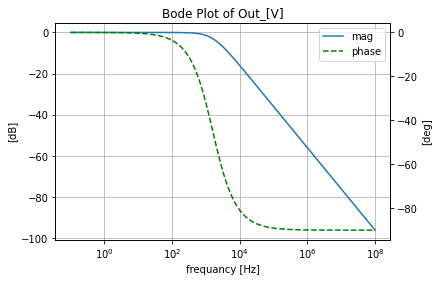

In [16]:
ac_p=eecomplex_plot_templets()

ac_p.bode_plot_one_templet(ac_rep_tool.ac_sim_mag_DF.index, ac_rep_tool.ac_sim_mag_DF['Out_[V][dB]'], ac_rep_tool.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Out_[V]')

And here we use the seconed Bode plot method to make the graph with the joined subplots but each subplot has the magnitude and phase respectivly

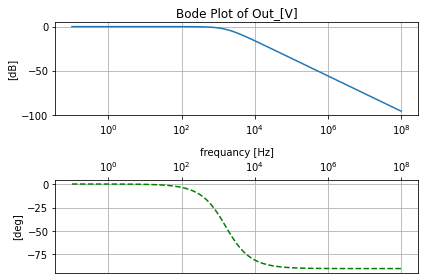

In [17]:
ac_p.bode_plot_two_templet(ac_rep_tool.ac_sim_mag_DF.index, ac_rep_tool.ac_sim_mag_DF['Out_[V][dB]'], ac_rep_tool.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Out_[V]')

Here is the Nichols plot pf out data with parmteriztion arrows showing the direction of increasing frequancy. Note that since that data was aquared logrimgly and the space inside `eecomplex_plot_templets.add_arrow` uses linear supdivsion the spacing on the arrows is going to follow logrithmicly as well

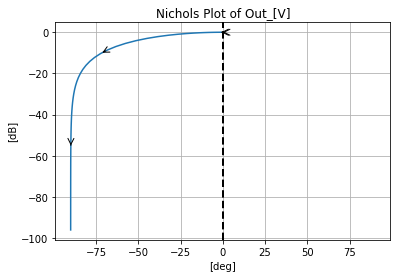

In [18]:
ac_p.nichols_plot_templet(ac_rep_tool.ac_sim_mag_DF['Out_[V][dB]'], ac_rep_tool.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Out_[V]')

And finally, we create the Nyquist plot again with the same parametricness shown by the arrows and with the same linear to log issue in their spacing.

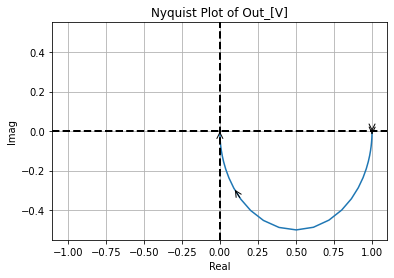

In [19]:
ac_p.nyquist_plot_templet(ac_rep_tool.ac_sim_real_DF['Out_[V]'], ac_rep_tool.ac_sim_imag_DF['Out_[V]'], 
                          title='Out_[V]')

### A quick filter exploration tool for the rest of this notebook¶

Here we create an easy use tool using mutable inheritance of our three ac tools wherein the  `__init__` method it performs the AC simulation, makes the representation transformations, and plot. And in the second method, we get grab the symbolic transfer function for the filter and pass it the same frequencies as the SPICE simulation and plot it on top of the SPICE simulation to examine any mild to gross divergence from the SPICE simulation and the symbolic.


In [20]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 qfilter_explorer class
#class to perform the anylsis of the filtes in Ch2 sec 2

class qfilter_explorer(ac_ease, ac_representation_tool, eecomplex_plot_templets):
    
    def __init__(self, circ, title, start_freq=.1@u_Hz, stop_freq=1@u_GHz):
        
        #do what ac_ease is supposed to do at startup
        #instainte the simulation from the circuit
        ac_ease.__init__(self, circ)
        #setup the simulation parameter with the helper method
        self.ac_sweep_setup(start_freq, stop_freq, 20, 'decade', True)
        #do the simulation
        self.do_ac_sim()
        
        
        #do what ac_representation_tool is supposed to do at startup
        #and pass in the selfs from `ac_ease`'s ac_resultsNB_DF
        ac_representation_tool.__init__(self, self.ac_resultsNB_DF)
        #generate the representations
        self.make_real_imag()
        self.make_mag_phase()
        
        
        eecomplex_plot_templets.__init__(self)


        fig=plt.figure(constrained_layout=True, figsize=(8,8))
        spec=fig.add_gridspec(2,2)

        ax_bode=fig.add_subplot(spec[0, :])
        self.bode_plot_one_templet(self.ac_sim_mag_DF.index, self.ac_sim_mag_DF['Out_[V][dB]'], self.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Out_[V]', ax=ax_bode)

        ax_nichols=fig.add_subplot(spec[1, 0])
        self.nichols_plot_templet(self.ac_sim_mag_DF['Out_[V][dB]'], self.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Out_[V]', ax=ax_nichols)

        ax_nyquist=fig.add_subplot(spec[1, 1])
        self.nyquist_plot_templet(self.ac_sim_real_DF['Out_[V]'], self.ac_sim_imag_DF['Out_[V]'], 
                          title='Out_[V]', ax=ax_nyquist)
        
        fig.suptitle(title)
    
    def symbolic_tf(self, filter_obj):
        self.symbolic_data=pd.DataFrame(index=self.ac_resultsNB_DF.index)
        
        f=self.symbolic_data.index.values
        
        #get the tf and get the data
        tf=filter_obj.get_tf()
        symbolic_data=tf.frequency_response(self.symbolic_data.index.values).astype('complex')
        
        self.symbolic_data['Out_sym_[V][dB]']=20*np.log10(np.abs(symbolic_data))
        self.symbolic_data['Out_sym_[V][deg]']=np.angle(symbolic_data, deg=True)

        fig, [ax_mag, ax_ph]=plt.subplots(nrows=2, ncols=1)
        
        self.bode_plot_two_templet(self.ac_sim_mag_DF.index, self.ac_sim_mag_DF['Out_[V][dB]'], self.ac_sim_phase_DF['Out_[V][deg]'], 
                          title='Simulated vs Symbolic Out_[V]', axs=[ax_mag, ax_ph])
        
        #add the symbolic data
        ax_mag.semilogx(f, self.symbolic_data['Out_sym_[V][dB]'], linestyle='-.' , alpha=0.5, label='symbolic')
        ax_mag.legend()
        
        ax_ph.semilogx(f, self.symbolic_data['Out_sym_[V][deg]'], color='orange' , alpha=0.75, label='symbolic')
        ax_ph.legend()    


,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


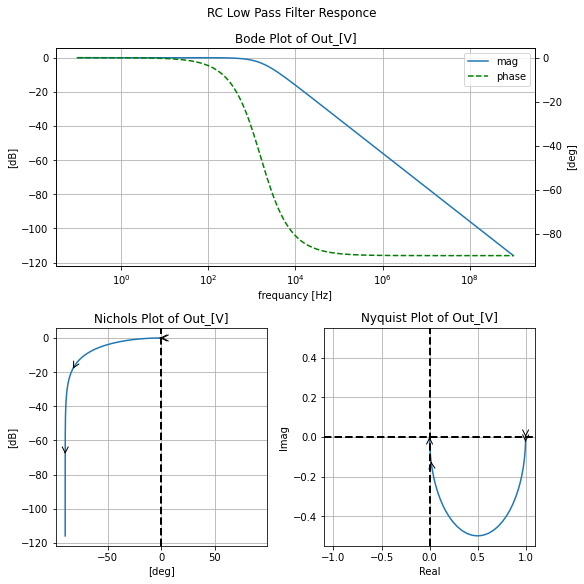

In [21]:
filter_responce=qfilter_explorer(circ, 'RC Low Pass Filter Responce');

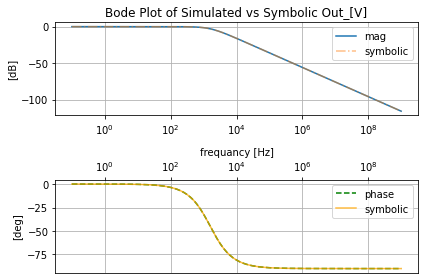

In [22]:
filter_responce.symbolic_tf(lowpassF)


##Equivalent Low Pass RL filter

Besides RC filters, there are of course RL dual filters. Where the equivalent RL filter values to any RC filter may be found via the equivalent time constant of the RC and RL implementation such that time constants must match ie: $$RC=\tau_{RC}=\tau_{RL}=L/R$$

In [23]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rl_lowpass filter class
#class with lcapy and skidl subcircuit to create an RL lowpass filter

class rl_lowpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    lowpass RL filter primitive
    """
    def __init__(self, subcirc_ref=None, L_value=1@u_H, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_H; Henery): the inductance in henrys for the RL inductive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RL resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RL_Lowpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RL lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.r=R(value=self.R_value, **Rref)
        
        self.l['p', 'n']+=term_0, term_2
        self.r[1, 2]+=self.l['n'], term_1
        
        if return_elements:
            return self.l, self.r
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'L 0_1 2_1; right, l=L{str(self.L_value)}')
        self.schematic.add(f'R 2_1 1_1; down, l=R{str(self.R_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value})
        
        if draw_me:
            self.schematic.draw()

    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)
        


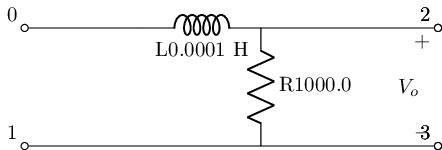

In [24]:
#instatate the rl_lowpass filter to 
rl_l=rl_lowpass(L_value=(1e3)**2 *.1e-9 @u_H, R_value=1e3)
rl_l.lcapy_self()

In [25]:
#get this filters abstract transfer function
rl_l.get_tf(with_values=False)

    R    
─────────
  ⎛    R⎞
L⋅⎜s + ─⎟
  ⎝    L⎠

In [26]:
#get this filters transfer function
rl_l.get_tf(with_values=True)

  10000000  
────────────
s + 10000000

In [27]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
rl_l.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
L1 In Out 0.0001H
R1 Out 0 1000.0
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


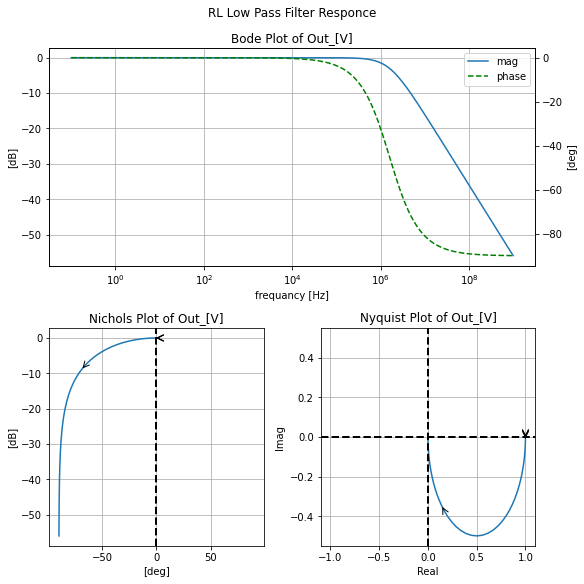

In [28]:
filter_responce=qfilter_explorer(circ, 'RL Low Pass Filter Responce');

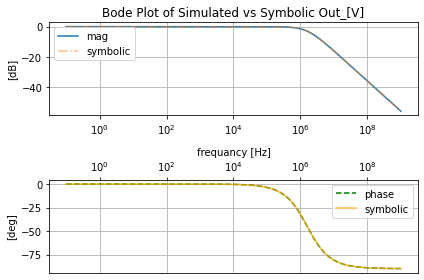

In [29]:
filter_responce.symbolic_tf(rl_l)

## The high pass filter from ALL ABOUT ELECTRONICS "RC High Pass Filter Explained" @~ 7:57min

As we saw with the RC and RL "Lowpass" filters they are named by the typical convention of how there implemented followed by some characteristic description of their magnitude response. Thus, lowpass filters minimally attenuate any single whose frequency content is less than the frequency of their 3dB knee. Whereas Highpass filters are the complement to that where they will highly attenuate any single whose frequency content is less than there 3dB knee as shown below using the example from ALL ABOUT ELELECTROINC YT video on “RC High Pass Filters”

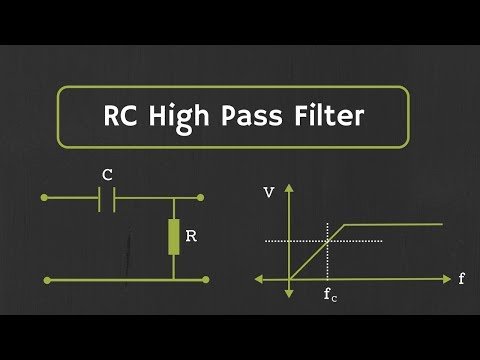

In [30]:
YouTubeVideo('9Dx0b0ukNAM', width=500, height=400, start=477)

In [31]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rc_highpass filter class
#class with lcapy and skidl subcircuit to create an RC highpass filter

class rc_highpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    highpass RC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RC_highpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RC highpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Cref={}
            Rref={}
            
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.c['p', 'n']+=term_0, term_2
        self.r[1, 2]+=self.c['n'], term_1
        
        if return_elements:
            return self.c, self.r
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add('C 0_1 2_1; right')
        self.schematic.add('R 2_1 1_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()

    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)
            
        


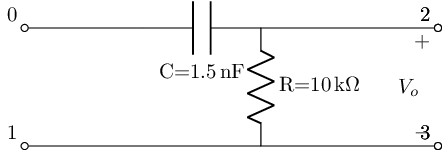

In [32]:
highpassF=rc_highpass(C_value=1.5@u_nF, R_value=10@u_kOhm)
highpassF.lcapy_self()

In [33]:
#get this filters abstract transfer function
highpassF.get_tf(with_values=False)

   s   
───────
     1 
s + ───
    C⋅R

In [34]:
#get this filters transfer function
highpassF.get_tf(with_values=True)

     s      
────────────
s + 200000/3

In [35]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
highpassF.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 In Out 1.5nF
R1 Out 0 10kOhm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


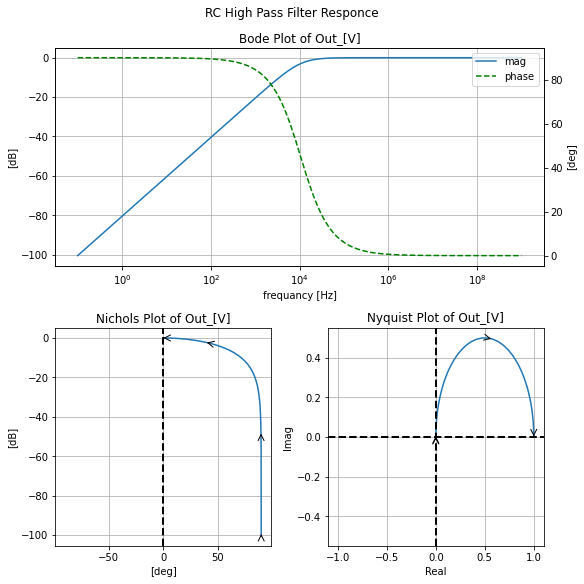

In [36]:
filter_responce=qfilter_explorer(circ, 'RC High Pass Filter Responce');

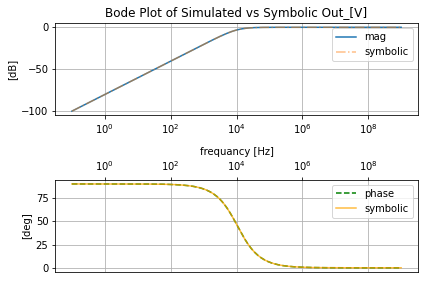

In [37]:
filter_responce.symbolic_tf(highpassF)

## RL Highpass

In [38]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rl_highpass filter class
#class with lcapy and skidl subcircuit to create an RL highpass filter

class rl_highpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    highpass RL filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RL inductive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RL resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RL_highpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RL highpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, self.l['p']
        self.l['p', 'n']+=term_2, term_3
        
        
        
        
        if return_elements:
            return self.l, self.r
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_1; right')
        self.schematic.add(f'L 2_1 1_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)
        
            


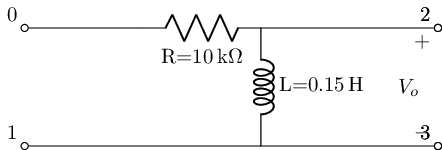

In [39]:
rl_h=rl_highpass(L_value=(10e3)**2 *1.5e-9 @u_H, R_value=10@u_kOhm)
rl_h.lcapy_self()

In [40]:
#get this filters abstract transfer function
rl_h.get_tf(with_values=False)

  s  
─────
    R
s + ─
    L

In [41]:
#get this filters transfer function
rl_h.get_tf(with_values=True)

     s      
────────────
s + 200000/3

In [42]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
rl_h.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
L1 Out 0 0.15H
R1 In Out 10kOhm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


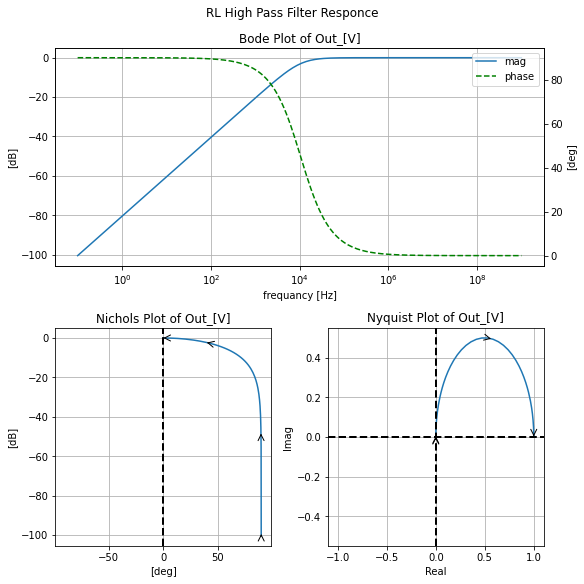

In [43]:
filter_responce=qfilter_explorer(circ, 'RL High Pass Filter Responce');

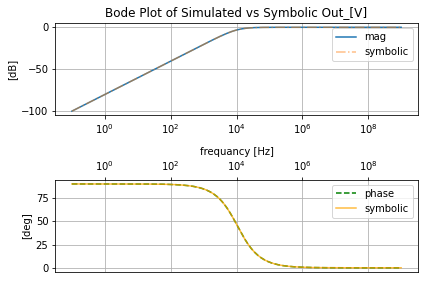

In [44]:
filter_responce.symbolic_tf(rl_h)

# First Order Cascade filter

Though as we will see there are more complex single filter designs that can implement a needed filter profile the other way to implement the needed filter profile is by cascading primitive filter sections as shown by ALL ABOUT ELELECTOINCS where here we will just implement the passive version of the cascaded bandpass filter shown below.

## The band pass filter from ALL ABOUT ELECTRONICS "Band Pass Filter and Band Stop Filter Explained" @~ 4:03min

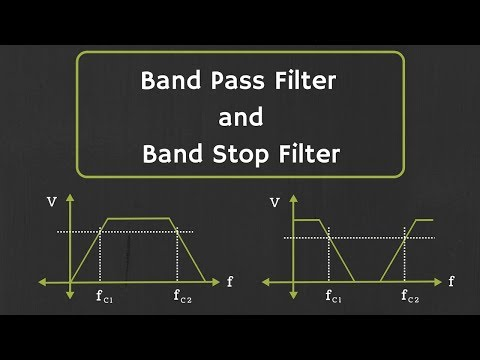

In [45]:
YouTubeVideo('dmPIydL0lyM', width=500, height=400, start=243)

In [46]:
reset()
net_in=Net('In'); net_inter=Net('Inter'); net_out=Net('Out')

vs=SINEV(amplitude=10@u_V, frequency=10@u_kHz)
vs['p', 'n']+=net_in, gnd

highpassFsection=rc_highpass(C_value=1.5@u_nF, R_value=10@u_kOhm)
highpassFsection.SKiDl(net_in, gnd, net_inter, gnd)

lowpassFsection=rc_lowpass(C_value=1.5@u_nF, R_value=1@u_kOhm)
lowpassFsection.SKiDl(net_inter, gnd, net_out, gnd)


circ=generate_netlist()
print(circ)

.title 
C1 In Inter 1.5nF
C2 Out 0 1.5nF
R1 Inter 0 10kOhm
R2 Inter Out 1kOhm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 10V 10kHz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


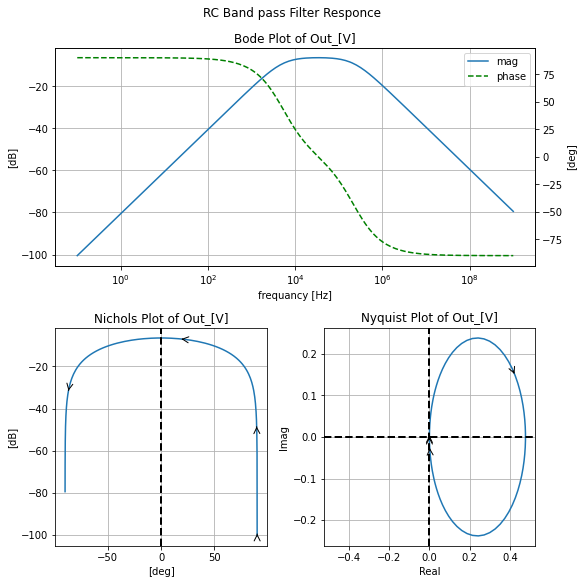

In [47]:
filter_responce=qfilter_explorer(circ, 'RC Band pass Filter Responce');

Becouse this is a cascaded filter to get the symbolic filter we need to casade them where for a recap of how to cascade filters in all the varies toplogies see https://x-engineer.org/graduate-engineering/signals-systems/control-systems/transfer-function-algebra/

In [48]:
cascade_tf=highpassFsection.get_tf() * lowpassFsection.get_tf() 
sym.sympify(cascade_tf)

           2000000⋅s            
────────────────────────────────
3⋅(s + 200000/3)⋅(s + 2000000/3)

And so for the sake of simplicity we will just reimpliment `qfilter_explorer.symbolic_tf` manulay here to compare the casdacded symbolic trnasfer fuction to the SPICE simulated results

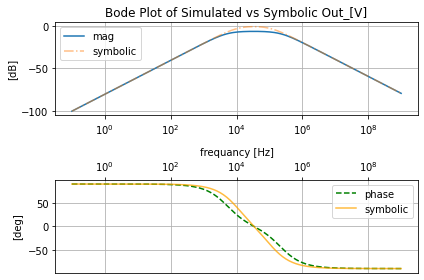

In [49]:
symbolic_data=pd.DataFrame(index=filter_responce.ac_resultsNB_DF.index)
f=symbolic_data.index.values

##bring the f through the sausage filter
symbolic_data_raw=cascade_tf.frequency_response(f).astype('complex')

symbolic_data['Out_sym_[V][dB]']=20*np.log10(np.abs(symbolic_data_raw))
symbolic_data['Out_sym_[V][deg]']=np.angle(symbolic_data_raw, deg=True)

fig, [ax_mag, ax_ph]=plt.subplots(nrows=2, ncols=1)

acplot=eecomplex_plot_templets()
acplot.bode_plot_two_templet(filter_responce.ac_sim_mag_DF.index, filter_responce.ac_sim_mag_DF['Out_[V][dB]'], filter_responce.ac_sim_phase_DF['Out_[V][deg]'], 
                  title='Simulated vs Symbolic Out_[V]', axs=[ax_mag, ax_ph])

#add the symbolic data
ax_mag.semilogx(f, symbolic_data['Out_sym_[V][dB]'], linestyle='-.' , alpha=0.5, label='symbolic')
ax_mag.legend()

ax_ph.semilogx(f, symbolic_data['Out_sym_[V][deg]'], color='orange' , alpha=0.75, label='symbolic')
ax_ph.legend();

# Second-Order Filters and resonators
Second-order filters are mostly designed around the following equations in their circuit implementation 

- Bandwidth ($B$):$B=\omega_2-\omega_1$
- Center Frequncy ($\omega_0$): $\omega_0=\dfrac{1}{\sqrt{LC}}=\sqrt{\omega_1 \omega_2}$
- The Q Factor in general: $Q=\dfrac{\omega_0}{B}$
    - Q for a series RLC is: $Q=\dfrac{1}{\omega_0 RC}$
    - Q for a parrel RLC is: $Q=\omega_0 RC$
 
 	And are called second-order since with having both a Capacitor and Inductor the differential equations in the time domain become second order. Below we will implement the four main second-order filter types: Lowpass, Highpass, Bandpass, Bandstop, in both their series and parral configurations. Where the templet around the values for the RLC elements used for these filters is the bandwidth frequencies of the ALL ABOUT CIRCUITS example of a passive cascaded filter above using a 50Ohm resistor, because.

## Series Based¶

In [50]:
V_out, V_in, angfreq_1, angfreq_2, angfreq_0, R_sym, C_sym, L_sym, Q_sym, f_sym, f0_sym, B_sym=sym.symbols('V_{out}, V_{in}, omega_1, omega_2, omega_0, R, C, L, Q, f, f_0, B' )
V_out, V_in, angfreq_1, angfreq_2, angfreq_0, R_sym, C_sym, L_sym, Q_sym, f_sym, f0_sym, B_sym

In [51]:
f1=10.61e3; f2=106.1e3
subs={R_sym:50}
subs[angfreq_1]=2*np.pi*f1; subs[angfreq_2]=2*np.pi*f2
subs[angfreq_0]=np.sqrt(subs[angfreq_1]*subs[angfreq_2])
subs[B_sym]=subs[angfreq_2]-subs[angfreq_1]
subs[Q_sym]=subs[angfreq_0]/subs[B_sym]
subs

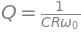

In [52]:
Qs_eq=sym.Eq(Q_sym, 1/(angfreq_0*R_sym*C_sym)); Qs_eq

In [53]:
subs[C_sym]=sym.solve(Qs_eq, C_sym)[0].subs(subs); subs

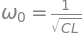

In [54]:
angfreq_0_eq=sym.Eq(angfreq_0, 1/sym.sqrt(L_sym*C_sym)); angfreq_0_eq

In [55]:
subs[L_sym]=sym.solve(angfreq_0_eq, L_sym)[0].subs(subs); subs

### RLC series lowpass

In [56]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_series_lowpass filter class
#class with lcapy and skidl subcircuit to create an RLC series lowpass filter

class rlc_series_lowpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    lowpass series RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_Lowpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC series lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, self.l[1]
        self.l[2]+=term_2, self.c['p']
        self.c['n']+=term_1, term_3
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=3')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add('R 0_1 N1; right')
        self.schematic.add('L N1 2_1; right')
        self.schematic.add('C 2_1 1_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


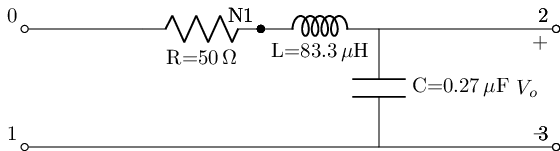

In [57]:
#instatate the rlc_lowpass filter 
lowpassRLC_s=rlc_series_lowpass(L_value=8.33e-5@u_H, C_value=2.7e-7@u_F, R_value=50@u_Ohm)
lowpassRLC_s.lcapy_self()

In [58]:
#get this filters abstract transfer function
lowpassRLC_s.get_tf(with_values=False)

                             1                             
───────────────────────────────────────────────────────────
    ⎛             ____________⎞ ⎛             ____________⎞
    ⎜            ╱    2       ⎟ ⎜            ╱    2       ⎟
    ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟ ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟
C⋅L⋅⎜s + ─── - ───────────────⎟⋅⎜s + ─── + ───────────────⎟
    ⎝    2⋅L        2⋅√C⋅L    ⎠ ⎝    2⋅L        2⋅√C⋅L    ⎠

In [59]:
#get this filters transfer function
lowpassRLC_s.get_tf(with_values=True)

                             1000000000000000                            
─────────────────────────────────────────────────────────────────────────
      ⎛    10000000⋅√25635   250000000⎞ ⎛    10000000⋅√25635   250000000⎞
22491⋅⎜s - ─────────────── + ─────────⎟⋅⎜s + ─────────────── + ─────────⎟
      ⎝          7497           833   ⎠ ⎝          7497           833   ⎠

In [60]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
lowpassRLC_s.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 Out 0 2.7e-07
L1 N_1 Out 8.33e-05H
R1 In N_1 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


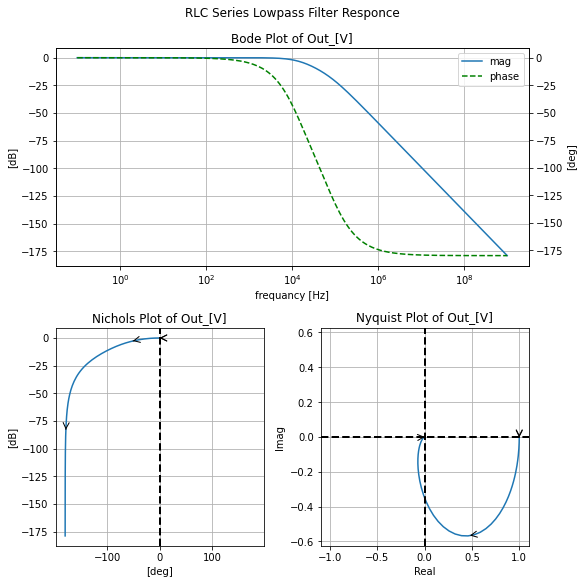

In [61]:
filter_responce=qfilter_explorer(circ, 'RLC Series Lowpass Filter Responce');

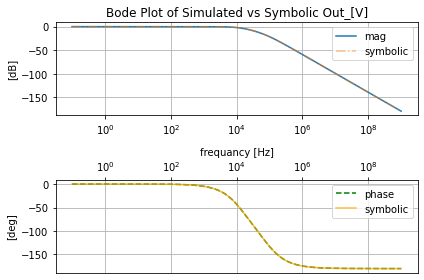

In [62]:
filter_responce.symbolic_tf(lowpassRLC_s)

### RLC series highpass

In [63]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_series_highpass filter class
#class with lcapy and skidl subcircuit to create an RLC series highpass filter

class rlc_series_highpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    highpass series RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_highpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC series highpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, self.c['p']
        self.c['n']+=term_2, self.l[1]
        self.l[2]+=term_1, term_3
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=3')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 N1; right')
        self.schematic.add(f'C N1 2_1; right')
        self.schematic.add(f'L 2_1 1_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


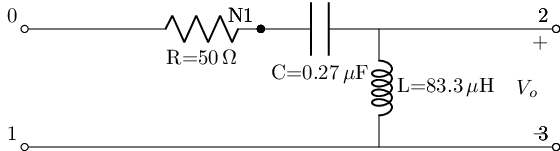

In [64]:
#instatate the rlc_highpass filter  
highpassRLC_s=rlc_series_highpass(L_value=8.33e-5@u_H, C_value=2.7e-7@u_F, R_value=50@u_Ohm)
highpassRLC_s.lcapy_self()

In [65]:
#get this filters abstract transfer function
highpassRLC_s.get_tf(with_values=False)

                            2                          
                           s                           
───────────────────────────────────────────────────────
⎛             ____________⎞ ⎛             ____________⎞
⎜            ╱    2       ⎟ ⎜            ╱    2       ⎟
⎜     R    ╲╱  C⋅R  - 4⋅L ⎟ ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟
⎜s + ─── - ───────────────⎟⋅⎜s + ─── + ───────────────⎟
⎝    2⋅L        2⋅√C⋅L    ⎠ ⎝    2⋅L        2⋅√C⋅L    ⎠

In [66]:
#get this filters transfer function
highpassRLC_s.get_tf(with_values=True)

                                  2                                
                                 s                                 
───────────────────────────────────────────────────────────────────
⎛    10000000⋅√25635   250000000⎞ ⎛    10000000⋅√25635   250000000⎞
⎜s - ─────────────── + ─────────⎟⋅⎜s + ─────────────── + ─────────⎟
⎝          7497           833   ⎠ ⎝          7497           833   ⎠

In [67]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
highpassRLC_s.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 N_1 Out 2.7e-07
L1 Out 0 8.33e-05H
R1 In N_1 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


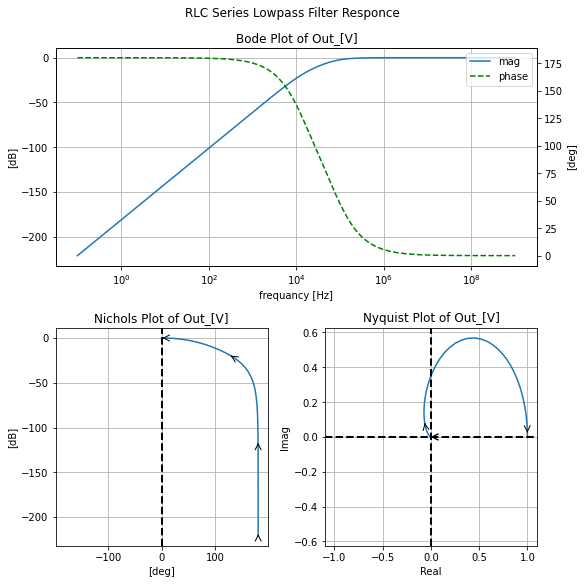

In [68]:
filter_responce=qfilter_explorer(circ, 'RLC Series Lowpass Filter Responce');

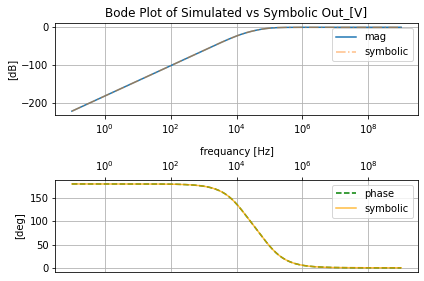

In [69]:
filter_responce.symbolic_tf(highpassRLC_s)

### RLC series bandpass

In [70]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_series_bandpass filter class
#class with lcapy and skidl subcircuit to create an RLC series bandpass filter

class rlc_series_bandpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    bandpass series RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_bandpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC series bandpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.l[1, 2]+=term_0, self.c['p']
        self.c['n']+=term_2, self.r[1]
        self.r[2]+=term_1, term_3
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=3')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'L 0_1 N1; right')
        self.schematic.add(f'C N1 2_1; right')
        self.schematic.add(f'R 2_1 1_1; down')
        
       
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


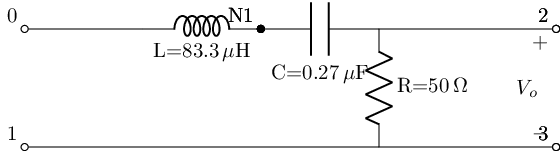

In [71]:
#instatate the rlc_bandpass filter  
bandpassRLC_s=rlc_series_bandpass(L_value=8.33e-5@u_H, C_value=2.7e-7@u_F, R_value=50@u_Ohm)
bandpassRLC_s.lcapy_self()

In [72]:
#get this filters abstract transfer function
bandpassRLC_s.get_tf(with_values=False)

                           R⋅s                           
─────────────────────────────────────────────────────────
  ⎛             ____________⎞ ⎛             ____________⎞
  ⎜            ╱    2       ⎟ ⎜            ╱    2       ⎟
  ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟ ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟
L⋅⎜s + ─── - ───────────────⎟⋅⎜s + ─── + ───────────────⎟
  ⎝    2⋅L        2⋅√C⋅L    ⎠ ⎝    2⋅L        2⋅√C⋅L    ⎠

In [73]:
#get this filters transfer function
bandpassRLC_s.get_tf(with_values=True)

                              500000000⋅s                              
───────────────────────────────────────────────────────────────────────
    ⎛    10000000⋅√25635   250000000⎞ ⎛    10000000⋅√25635   250000000⎞
833⋅⎜s - ─────────────── + ─────────⎟⋅⎜s + ─────────────── + ─────────⎟
    ⎝          7497           833   ⎠ ⎝          7497           833   ⎠

In [74]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
bandpassRLC_s.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 N_1 Out 2.7e-07
L1 In N_1 8.33e-05H
R1 Out 0 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


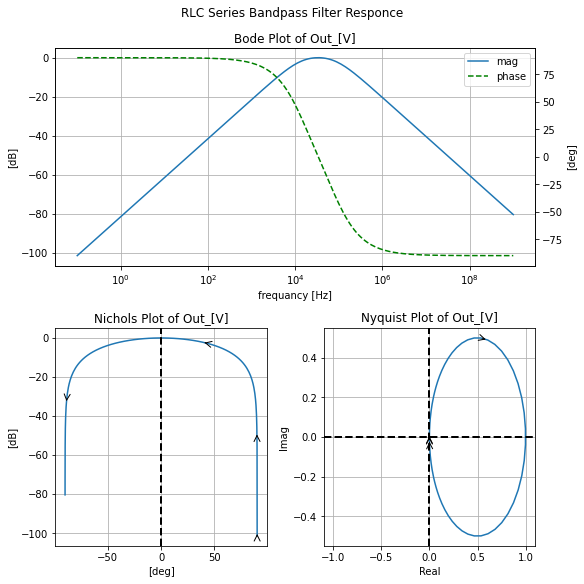

In [75]:
filter_responce=qfilter_explorer(circ, 'RLC Series Bandpass Filter Responce');

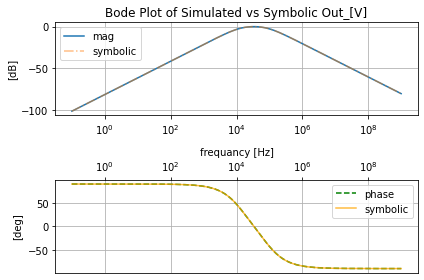

In [76]:
filter_responce.symbolic_tf(bandpassRLC_s)

### RLC series bandstop

In [77]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_series_bandstop filter class
#class with lcapy and skidl subcircuit to create an RLC series bandstop filter

class rlc_series_bandstop():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    bandstop series RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_bandstop - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC series bandstop filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, term_2
        self.l[1, 2]+=self.r[2], self.c['p']
        self.c['n']+=term_1, term_3
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=2')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_1; right')
        self.schematic.add(f'L 2_1 N1; down')
        self.schematic.add(f'C N1 1_1; down')
        
       
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


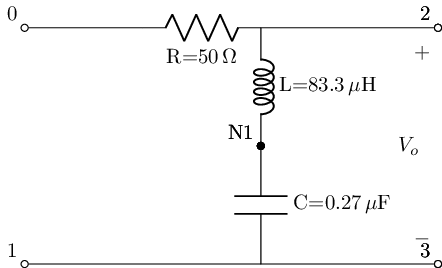

In [78]:
#instatate the rlc_bandstop filter
bandstopRLC_s=rlc_series_bandstop(L_value=8.33e-5@u_H, C_value=2.7e-7@u_F, R_value=50@u_Ohm)
bandstopRLC_s.lcapy_self()

In [79]:
#get this filters abstract transfer function
bandstopRLC_s.get_tf(with_values=False)

                ⎛      ⅉ  ⎞ ⎛      ⅉ  ⎞                
                ⎜s - ─────⎟⋅⎜s + ─────⎟                
                ⎝    √C⋅√L⎠ ⎝    √C⋅√L⎠                
───────────────────────────────────────────────────────
⎛             ____________⎞ ⎛             ____________⎞
⎜            ╱    2       ⎟ ⎜            ╱    2       ⎟
⎜     R    ╲╱  C⋅R  - 4⋅L ⎟ ⎜     R    ╲╱  C⋅R  - 4⋅L ⎟
⎜s + ─── - ───────────────⎟⋅⎜s + ─── + ───────────────⎟
⎝    2⋅L        2⋅√C⋅L    ⎠ ⎝    2⋅L        2⋅√C⋅L    ⎠

In [80]:
#get this filters transfer function
bandstopRLC_s.get_tf(with_values=True)

            ⎛    10000000⋅√510⋅ⅉ⎞ ⎛    10000000⋅√510⋅ⅉ⎞            
            ⎜s - ───────────────⎟⋅⎜s + ───────────────⎟            
            ⎝          1071     ⎠ ⎝          1071     ⎠            
───────────────────────────────────────────────────────────────────
⎛    10000000⋅√25635   250000000⎞ ⎛    10000000⋅√25635   250000000⎞
⎜s - ─────────────── + ─────────⎟⋅⎜s + ─────────────── + ─────────⎟
⎝          7497           833   ⎠ ⎝          7497           833   ⎠

In [81]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
bandstopRLC_s.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 N_1 0 2.7e-07
L1 Out N_1 8.33e-05H
R1 In Out 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


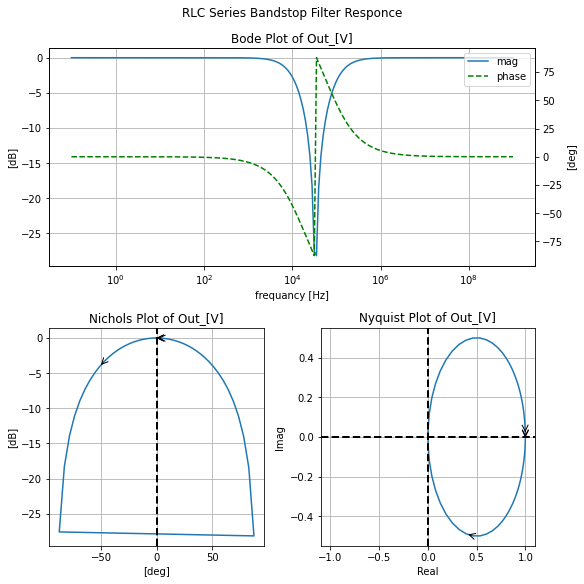

In [82]:
filter_responce=qfilter_explorer(circ, 'RLC Series Bandstop Filter Responce');

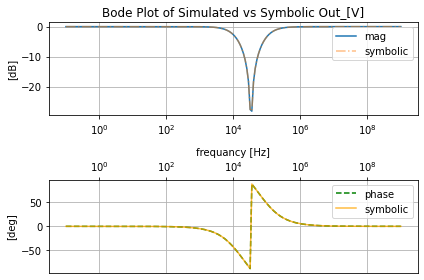

In [83]:
filter_responce.symbolic_tf(bandstopRLC_s)

## Parallel Based¶

In [84]:
V_out, V_in, angfreq_1, angfreq_2, angfreq_0, R_sym, C_sym, L_sym, Q_sym, f_sym, f0_sym, B_sym=sym.symbols('V_{out}, V_{in}, omega_1, omega_2, omega_0, R, C, L, Q, f, f_0, B' )
V_out, V_in, angfreq_1, angfreq_2, angfreq_0, R_sym, C_sym, L_sym, Q_sym, f_sym, f0_sym, B_sym

In [85]:
f1=10.61e3; f2=106.1e3
subs={R_sym:50}
subs[angfreq_1]=2*np.pi*f1; subs[angfreq_2]=2*np.pi*f2
subs[angfreq_0]=np.sqrt(subs[angfreq_1]*subs[angfreq_2])
subs[B_sym]=subs[angfreq_2]-subs[angfreq_1]
subs[Q_sym]=subs[angfreq_0]/subs[B_sym]
subs

In [86]:
Qp_eq=sym.Eq(Q_sym, angfreq_0*R_sym*C_sym); Qp_eq

In [87]:
subs[C_sym]=sym.solve(Qp_eq, C_sym)[0].subs(subs); subs

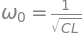

In [88]:
angfreq_0_eq=sym.Eq(angfreq_0, 1/sym.sqrt(L_sym*C_sym)); angfreq_0_eq

In [89]:
subs[L_sym]=sym.solve(angfreq_0_eq, L_sym)[0].subs(subs); subs

### RLC parallel lowpass 

In [90]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_parallel_lowpass filter class
#class with lcapy and skidl subcircuit to create an RLC parallel lowpass filter

class rlc_parallel_lowpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    lowpass parallel RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_Lowpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC parallel lowpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.l[1, 2]+=term_0, term_2
        self.c['p', 'n']+=term_2, term_1
        self.r[1, 2]+=term_2, term_3
        self.c['n']+=self.r[2]
        
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=2')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'L 0_1 2_2; right')
        self.schematic.add(f'C 2_2 1_1; down')
        self.schematic.add('W 2_2 2_1; right')
        self.schematic.add('W 1_1 3_1; right')
        self.schematic.add(f'R 2_1 3_1; down')

       
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 3_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


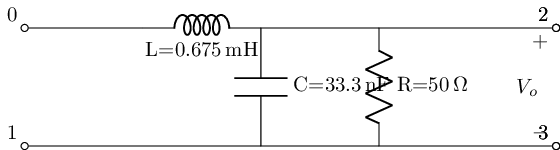

In [91]:
#instatate the rlc_lowpass filter  
lowpassRLC_p=rlc_parallel_lowpass(L_value=.0006750@u_H, C_value=3.33e-8@u_F, R_value=50@u_Ohm)
lowpassRLC_p.lcapy_self()

In [92]:
#get this filters abstract transfer function
lowpassRLC_p.get_tf(with_values=False)

                                 1                                 
───────────────────────────────────────────────────────────────────
    ⎛               ______________⎞ ⎛               ______________⎞
    ⎜              ╱        2     ⎟ ⎜              ╱        2     ⎟
    ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟ ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟
C⋅L⋅⎜s + ───── - ─────────────────⎟⋅⎜s + ───── + ─────────────────⎟
    ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠ ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠

In [93]:
#get this filters transfer function
lowpassRLC_p.get_tf(with_values=True)

                          400000000000000                           
────────────────────────────────────────────────────────────────────
     ⎛    20000000⋅√114   100000000⎞ ⎛    20000000⋅√114   100000000⎞
8991⋅⎜s - ───────────── + ─────────⎟⋅⎜s + ───────────── + ─────────⎟
     ⎝         999           333   ⎠ ⎝         999           333   ⎠

In [94]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
lowpassRLC_p.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 Out 0 3.33e-08
L1 In Out 0.000675H
R1 Out 0 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


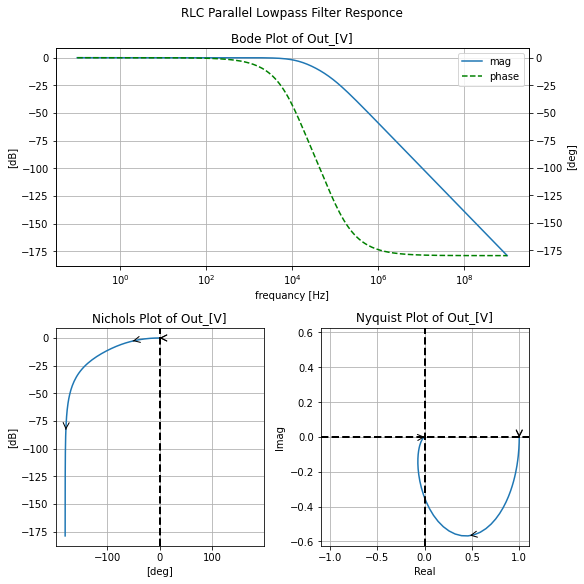

In [95]:
filter_responce=qfilter_explorer(circ, 'RLC Parallel Lowpass Filter Responce');

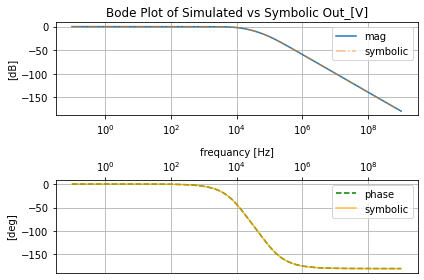

In [96]:
filter_responce.symbolic_tf(lowpassRLC_p)

### RLC parallel highpass 

In [97]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_parallel_highpass filter class
#class with lcapy and skidl subcircuit to create an RLC parallel highpass filter

class rlc_parallel_highpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    highpass parallel RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_highpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC parallel highpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.c['p', 'n']+=term_0, term_2
        self.r[1, 2]+=term_2, term_1
        self.l[1, 2]+=term_2, term_3
        self.l[2]+=self.r[2]
        
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=2')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'C 0_1 2_2; right')
        self.schematic.add(f'R 2_2 1_1; down')
        self.schematic.add('W 2_2 2_1; right')
        self.schematic.add('W 1_1 3_1; right')
        self.schematic.add(f'L 2_1 3_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 3_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


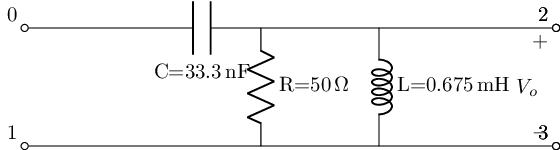

In [98]:
#instatate the rlc_highpass filter
highpassRLC_p=rlc_parallel_highpass(L_value=.0006750@u_H, C_value=3.33e-8@u_F, R_value=50@u_Ohm)
highpassRLC_p.lcapy_self()

In [99]:
#get this filters abstract transfer function
highpassRLC_p.get_tf(with_values=False)

                                2                              
                               s                               
───────────────────────────────────────────────────────────────
⎛               ______________⎞ ⎛               ______________⎞
⎜              ╱        2     ⎟ ⎜              ╱        2     ⎟
⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟ ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟
⎜s + ───── - ─────────────────⎟⋅⎜s + ───── + ─────────────────⎟
⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠ ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠

In [100]:
#get this filters transfer function
highpassRLC_p.get_tf(with_values=True)

                                2                              
                               s                               
───────────────────────────────────────────────────────────────
⎛    20000000⋅√114   100000000⎞ ⎛    20000000⋅√114   100000000⎞
⎜s - ───────────── + ─────────⎟⋅⎜s + ───────────── + ─────────⎟
⎝         999           333   ⎠ ⎝         999           333   ⎠

In [101]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
highpassRLC_p.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 In Out 3.33e-08
L1 Out 0 0.000675H
R1 Out 0 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


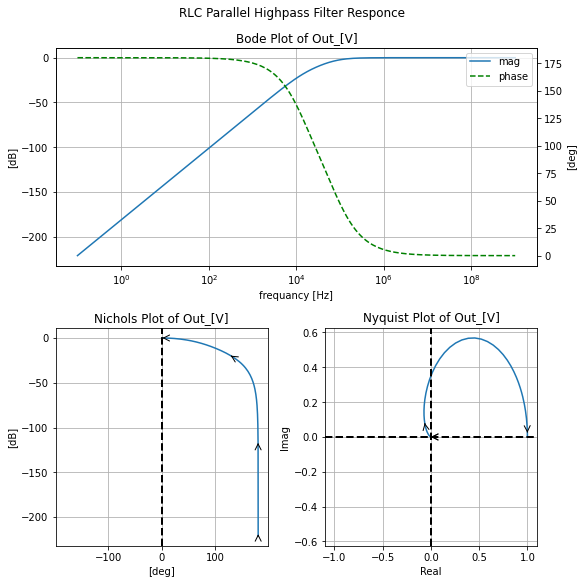

In [102]:
filter_responce=qfilter_explorer(circ, 'RLC Parallel Highpass Filter Responce');

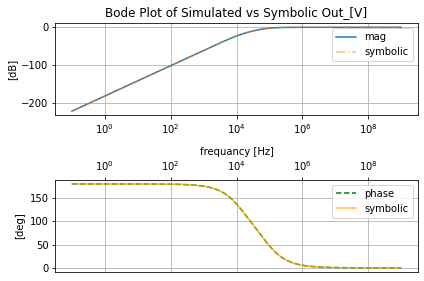

In [103]:
filter_responce.symbolic_tf(highpassRLC_p)

### RLC parallel bandpass 

In [104]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_parallel_bandpass filter class
#class with lcapy and skidl subcircuit to create an RLC parallel bandpass filter

class rlc_parallel_bandpass():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    bandpass parallel RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_bandpass - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC parallel bandpass filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.r[1, 2]+=term_0, term_2
        self.c['p', 'n']+=term_2, term_1
        self.l[1, 2]+=term_2, term_3
        self.l[2]+=self.c['n']
        
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 1_1; right=2')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_2; right')
        self.schematic.add(f'C 2_2 1_1; down')
        self.schematic.add('W 2_2 2_1; right')
        self.schematic.add('W 1_1 3_1; right')
        self.schematic.add(f'L 2_1 3_1; down')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 3_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


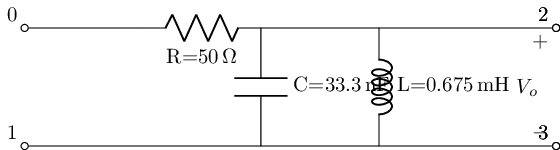

In [105]:
#instatate the rlc_bandpass filter
bandpassRLC_p=rlc_parallel_bandpass(L_value=.0006750@u_H, C_value=3.33e-8@u_F, R_value=50@u_Ohm)
bandpassRLC_p.lcapy_self()

In [106]:
#get this filters abstract transfer function
bandpassRLC_p.get_tf(with_values=False)

                                 s                                 
───────────────────────────────────────────────────────────────────
    ⎛               ______________⎞ ⎛               ______________⎞
    ⎜              ╱        2     ⎟ ⎜              ╱        2     ⎟
    ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟ ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟
C⋅R⋅⎜s + ───── - ─────────────────⎟⋅⎜s + ───── + ─────────────────⎟
    ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠ ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠

In [107]:
#get this filters transfer function
bandpassRLC_p.get_tf(with_values=True)

                            200000000⋅s                            
───────────────────────────────────────────────────────────────────
    ⎛    20000000⋅√114   100000000⎞ ⎛    20000000⋅√114   100000000⎞
333⋅⎜s - ───────────── + ─────────⎟⋅⎜s + ───────────── + ─────────⎟
    ⎝         999           333   ⎠ ⎝         999           333   ⎠

In [108]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
bandpassRLC_p.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 Out 0 3.33e-08
L1 Out 0 0.000675H
R1 In Out 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


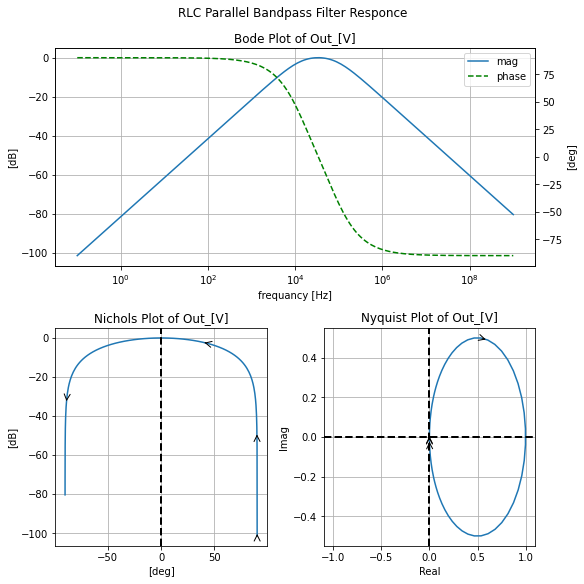

In [109]:
filter_responce=qfilter_explorer(circ, 'RLC Parallel Bandpass Filter Responce');

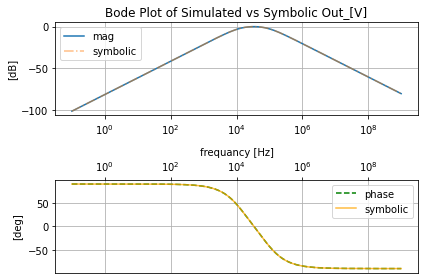

In [110]:
filter_responce.symbolic_tf(bandpassRLC_p)

### RLC parallel bandstop

In [111]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 rlc_parallel_bandstop filter class
#class with lcapy and skidl subcircuit to create an RLC parallel bandstop filter

class rlc_parallel_bandstop():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    bandstop parallel RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L_value=1@u_H, C_value=1@u_F, R_value=1@u_Ohm):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L_value (float; 1@u_F; Henerys): the inductance in farads for the RLC inductive element
            C_value (float; 1@u_F; Farads): the capacitance in farads for the RLC capacitive element
            R_value (float; 1@u_Ohm; Ohms): the resistance in ohms for the RLC resistive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_bandstop - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC parallel bandstop filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            Lref={'ref':f'L_{self.subcirc_ref}'}
            Cref={'ref':f'C_{self.subcirc_ref}'}
            Rref={'ref':f'R_{self.subcirc_ref}'}
        else:
            Lref={}
            Cref={}
            Rref={}
        
        self.l=L(value=self.L_value, **Lref)
        self.c=C(value=self.C_value, **Cref)
        self.r=R(value=self.R_value, **Rref)
        
        self.c['p', 'n']+=term_0, term_2
        self.l[1, 2]+=term_0, term_2
        self.r[1, 2]+=term_2, term_3
        self.r[2]+=term_1
        
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - get the Vin statement into the schematic
        
        """
        
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 0 0_1; right')
        self.schematic.add('W 1 3_1; right=3.5')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add('W 0_1, 0_2; up=.3')
        self.schematic.add(f'L 0_2 2_3; right')
        self.schematic.add('W 2_3 2_2; down=.3')
        
        self.schematic.add('W 0_1, 0_3; down=.3')
        self.schematic.add(f'C 0_3 2_4; right')
        self.schematic.add('W 2_4 2_2; up=.3')

        self.schematic.add(f'R 2_1 3_1; down')

        
        self.schematic.add('W 2_2 2_1; right')
        self.schematic.add('W 2_1 2; right')
        self.schematic.add('W 3_1 3; right')
        self.schematic.add('P2 2 3; down, v=V_o')
        
        if with_values:
            self.schematic=self.schematic.subs({'R':self.R_value, 'L':self.L_value, 'C':self.C_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)


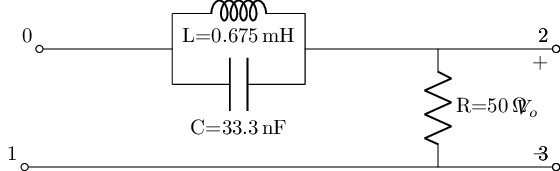

In [112]:
#instatate the rc_bandpass filter to 
bandstopRLC_p=rlc_parallel_bandstop(L_value=.0006750@u_H, C_value=3.33e-8@u_F, R_value=50@u_Ohm)
bandstopRLC_p.lcapy_self()

In [113]:
#get this filters abstract transfer function
bandstopRLC_p.get_tf(with_values=False)

                    ⎛      ⅉ  ⎞ ⎛      ⅉ  ⎞                    
                    ⎜s - ─────⎟⋅⎜s + ─────⎟                    
                    ⎝    √C⋅√L⎠ ⎝    √C⋅√L⎠                    
───────────────────────────────────────────────────────────────
⎛               ______________⎞ ⎛               ______________⎞
⎜              ╱        2     ⎟ ⎜              ╱        2     ⎟
⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟ ⎜      1     ╲╱  - 4⋅C⋅R  + L ⎟
⎜s + ───── - ─────────────────⎟⋅⎜s + ───── + ─────────────────⎟
⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠ ⎝    2⋅C⋅R        2⋅C⋅√L⋅R    ⎠

In [114]:
#get this filters transfer function
bandstopRLC_p.get_tf(with_values=True)

          ⎛    20000000⋅√111⋅ⅉ⎞ ⎛    20000000⋅√111⋅ⅉ⎞          
          ⎜s - ───────────────⎟⋅⎜s + ───────────────⎟          
          ⎝          999      ⎠ ⎝          999      ⎠          
───────────────────────────────────────────────────────────────
⎛    20000000⋅√114   100000000⎞ ⎛    20000000⋅√114   100000000⎞
⎜s - ───────────── + ─────────⎟⋅⎜s + ───────────── + ─────────⎟
⎝         999           333   ⎠ ⎝         999           333   ⎠

In [115]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
bandstopRLC_p.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
C1 In Out 3.33e-08
L1 In Out 0.000675H
R1 Out 0 50Ohm
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


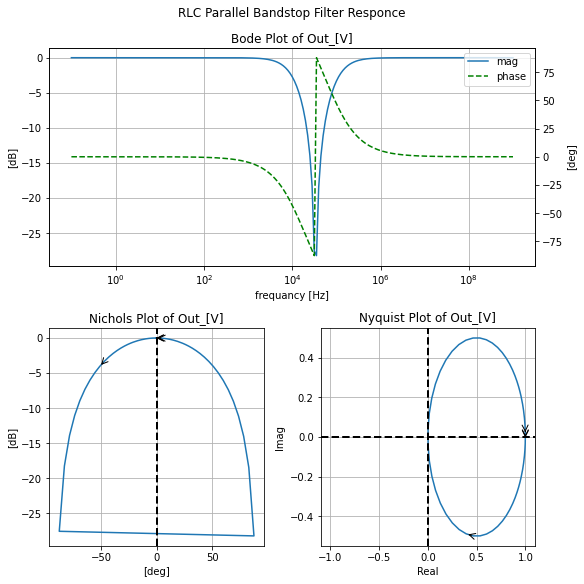

In [116]:
filter_responce=qfilter_explorer(circ, 'RLC Parallel Bandstop Filter Responce');

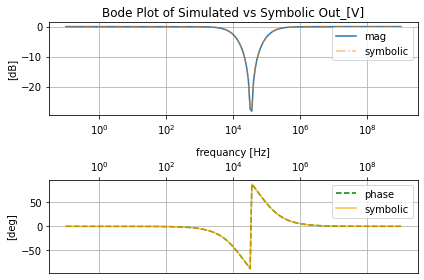

In [117]:
filter_responce.symbolic_tf(bandstopRLC_p)

# All Pass filters

The naming of filters as has been seen is based on the shape of the Bode Magnitude Plot and for the most part, Phase has kind of been a ride along part of the filter design. Stating that, the name for an All-Pass filter is misleading; the better name is a Phase Shaping filter. These Filters ideally do not affect the magnitude of the signal passed through them and instead affect the phase. Here we will look at the lattice All-Pass filter for the low-frequency phase from the following Wikipedia article 

https://en.wikipedia.org/wiki/Lattice_phase_equaliser


In [118]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 2 lc_balanced_allpass_lowfreq_lattice_filt filter class
#class with lcapy and skidl subcircuit to create an lc all-pass filter

class lc_balanced_allpass_lowfreq_lattice_filt():
    """
    holding class for SkiDl subcircuit and lcapy schematic of a
    bandstop parallel RLC filter primitive
    """
    
    def __init__(self, subcirc_ref=None, L1_value=1@u_H, L2_value=1@u_H,  C1_value=1@u_F, C2_value=1@u_F):
        """
        Args:
            subcirc_ref (str): reference to use for the base of the internal elements
            L1_value (float; 1@u_F; Henerys): the inductance in farads for the top inductive element
            L2_value (float; 1@u_F; Henerys): the inductance in farads for the bottom inductive element
            C1_value (float; 1@u_F; Farads): the capacitance in farads for the term 2 to term 1 capacitive element
            C2_value (float; 1@u_F; Farads): the capacitance in farads for the term 0 to term 2 capacitive element

        Returns:
            None
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L1_value=L1_value
        self.L2_value=L2_value
        self.C1_value=C1_value
        self.C2_value=C2_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Terminals:
        term_0, term_1, term_2, term_3
        
        Terminals are defined via:
        ```
        Left_Termanals - RLC_s_bandstop - Right_Termanals
                             +----+  
        Postive V_i   term_0-|0  2|-term_2     Postive V_o
        Negtive V_i   term_1-|1  3|-term_3     Negtive V_o
                             +----+
        ```
        
        Args:
            return_internls (bool; False): If True return out the internal Voltage Source,
                and Resistance objects in this package
        Returns:
            Returns elements to circuit RLC parallel bandstop filter part element object and if `return_internls`
            is True will return the internal voltage and resistance objects in that order 
        """
        if self.subcirc_ref!=None:
            L1ref={'ref':f'L_{self.subcirc_ref}1'}
            L2ref={'ref':f'L_{self.subcirc_ref}2'}

            C1ref={'ref':f'C_{self.subcirc_ref}1'}
            C2ref={'ref':f'C_{self.subcirc_ref}2'}
        else:
            L1ref={}
            L2ref={}
            
            C1ref={}
            C2ref={}
        
        self.l1=L(value=self.L1_value, **L1ref)
        self.l2=L(value=self.L2_value, **L2ref)

        self.c1=C(value=self.C1_value, **C1ref)
        self.c2=C(value=self.C2_value, **C2ref)
        
        
        term_0+=self.l1[1], self.c2['p']
        term_1+=self.l2[1], self.c1['n']
        term_2+=self.l1[2], self.c1['p']
        term_3+=self.l2[2], self.c2['n']   
        
        
        
        
        if return_elements:
            return self.c, self.r, self.l
    
    def lcapy_self(self, draw_me=True, with_values=True):
        """
        Creates a lcapy schematic of this classes filter that
        can be used for amongst other things: draw a basic schematic
        of this class filter, extract the transfer function, 
        exstract the 2Port Repersntation
        
        Args:
            draw_me (bool): will draw a schematic of this classes filter schematic
            
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
        Return:
            the lcapys circuit object is stored in `self.schematic` and will
            have abstract sympy variable for the elements if `with_values` is False
            and will draw the schematic of just this classes filter if `draw_me` is True
        
        TODO:
            - must draw this better
            - get the Vin statement into the schematic
            
        
        """
        
        self.schematic=kiwi.Circuit()
        
        self.schematic=kiwi.Circuit()
        #self.schematic.add('W 0 0; right')
        #self.schematic.add('W 1 3; right=3.5')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        #It ant pretty but it works
        self.schematic.add('W 0 0_3; right')
        self.schematic.add(f'L1 0_3 2_2; right')
        self.schematic.add('W 2_2 2; right')

        self.schematic.add('W 0 0_2; rotate=-45')
        self.schematic.add(f'C2 0_2 3; rotate=-45')
        
        self.schematic.add(f'C1 2 1_2; rotate=225')
        self.schematic.add(f'W 1_2 1; rotate=225')
        
        self.schematic.add('W 1 1_3; right')
        self.schematic.add(f'L2 1_3 3_2; right=2')
        self.schematic.add('W 3_2 3; right')

        
        if with_values:
            self.schematic=self.schematic.subs({'L1':self.L1_value, 'L2':self.L2_value, 
                                                'C1':self.C1_value, 'C2':self.C2_value})
        
        if draw_me:
            self.schematic.draw()
    
    def get_tf(self, with_values=True, ZPK=True):
        """
        will extract the symbolic transfer function for this filter
        
        Args:
            with_values (bool): will push the filters element values into
                the resulting lcapy circuit object in place of abstract sympy variables
            
            ZPK (bool): if True will try to return the TF in zero-pole-gain form
                else will try to return the TF in canonical form 
                where the unity coefficient is the highest power of the denominator
        
        """
        self.lcapy_self(draw_me=False, with_values=with_values)
        self.tf=self.schematic.transfer(0, 1, 2, 3)
        
        if ZPK:
            return self.tf.ZPK()
        else:
            return self.tf.canonical()
        
    def get_twoPort(self, network_rep='Y', with_values=True):
        """
        Gets the 2Port network representation of this filter.
        The 2Port representation can be controlled
        
        Args:
            network_rep (str; 'Y'): control string for what
                representation is used to choose from:
                
                'Z': two-port Z-parameters matrix
                'Y': two-port Y-parameters matrix
                'H': two-port H-parameters matrix
                'G': two-port G-parameters matrix
                'ABCD': two-port A-parameters matrix
                'invABCD': two-port B-parameters matrix
                'S': two-port S-parameters matrix
                'T': two-port T-parameters matrix
                
                
        """
        
        self.lcapy_self(draw_me=False, with_values=with_values)
        
        #create an action dict to get the 2P rep
        rep_actions={
            'Z':lambda x: x.Zparams(0, 1, 2, 1),
            'Y':lambda x: x.Yparams(0, 1, 2, 1), 
            'H':lambda x: x.Hparams(0, 1, 2, 1),
            'G':lambda x: x.Gparams(0, 1, 2, 1),
            'ABCD':lambda x: x.Aparams(0, 1, 2, 1),
            'invABCD':lambda x: x.Bparams(0, 1, 2, 1),
            'S':lambda x: x.Sparams(0, 1, 2, 1),
            'T':lambda x: x.Tparams(0, 1, 2, 1),
        }
        
        assert network_rep in rep_actions.keys(), f'`{network_rep}` is not 2Port rep'
        
        return rep_actions[network_rep](self.schematic)



If you're wondering what a lattice filter is, the fact of the matter is that you have seen them before in terms of bridge circuits. See the following Wikipedia article on Lattice Networks 

https://www.eeeguide.com/wp-content/uploads/2019/11/Lattice-Network.jpg


Distance conflict 0.2761423749153966 vs 1.0 in horizontal graph for Wanon2 between nodes (2_2) and (2), due to incompatible sizes


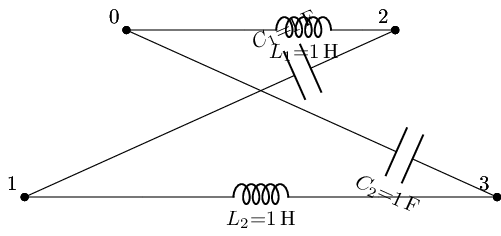

In [119]:
#instatate the allpass latice filter to 
allpasslat_lf=lc_balanced_allpass_lowfreq_lattice_filt()
allpasslat_lf.lcapy_self()

In [120]:
#get this filters abstract transfer function
allpasslat_lf.get_tf(with_values=False)

 ⎛                 1             ⎞ ⎛                 1             ⎞ ⎛        
-⎜s - ───────────────────────────⎟⋅⎜s + ───────────────────────────⎟⋅⎜s - ────
 ⎜    4 ____ 4 ____ 4 ____ 4 ____⎟ ⎜    4 ____ 4 ____ 4 ____ 4 ____⎟ ⎜    4 __
 ⎝    ╲╱ C₁ ⋅╲╱ C₂ ⋅╲╱ L₁ ⋅╲╱ L₂ ⎠ ⎝    ╲╱ C₁ ⋅╲╱ C₂ ⋅╲╱ L₁ ⋅╲╱ L₂ ⎠ ⎝    ╲╱ C
──────────────────────────────────────────────────────────────────────────────
                             ⎛          ⅉ      ⎞ ⎛          ⅉ      ⎞ ⎛        
                             ⎜s - ─────────────⎟⋅⎜s + ─────────────⎟⋅⎜s - ────
                             ⎜      ____   ____⎟ ⎜      ____   ____⎟ ⎜      __
                             ⎝    ╲╱ C₁ ⋅╲╱ L₁ ⎠ ⎝    ╲╱ C₁ ⋅╲╱ L₁ ⎠ ⎝    ╲╱ C

         ⅉ             ⎞ ⎛                 ⅉ             ⎞ 
───────────────────────⎟⋅⎜s + ───────────────────────────⎟ 
__ 4 ____ 4 ____ 4 ____⎟ ⎜    4 ____ 4 ____ 4 ____ 4 ____⎟ 
₁ ⋅╲╱ C₂ ⋅╲╱ L₁ ⋅╲╱ L₂ ⎠ ⎝    ╲╱ C₁ ⋅╲╱ C₂ ⋅╲╱ L₁ ⋅╲╱ L₂ ⎠ 
────────────────────────────────────────────────

In [121]:
#get this filters transfer function
allpasslat_lf.get_tf(with_values=True)

-(s - 1)⋅(s + 1) 
─────────────────
 (s - ⅉ)⋅(s + ⅉ) 

In [122]:
reset()
#create the nets; the last one is needed to deal with singularity issues when dealing with lattice circuits and ground
net_in=Net('In'); net_out=Net('Out'); net_outlower=Net('Out2')
#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd
#net_in+=dummy_1[2]

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
#but need to add dummy resistors to deal with singular issues and get solvable matric
dummy_botin=R(value=0, ref='dummy')
dummy_botin[1]+=gnd

dummy_botout=R(value=0, ref='dummy')
dummy_botout[2]+=gnd
allpasslat_lf.SKiDl(net_in, dummy_botin[2], net_out, dummy_botout[1])

circ=generate_netlist()
print(circ)


.title 
C1 Out N_1 1
C2 In N_2 1
L1 In Out 1H
L2 N_1 N_2 1H
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy 0 N_1 0
Rdummy_1 N_2 0 0




No errors or warnings found during netlist generation.



The `dummy_bot*` resistors that are in the simulation are needed in order for SPICE to no longer throw a singular matrix error. Where the test circuit is drawn below. This might not be needed if the output (terminal 3) of the lattice filter was allowed to float. Floating circuits will be discussed in the next section on transformers in detail. Here all inputs and outputs will be referenced to ground.

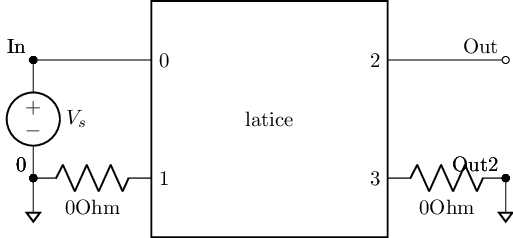

In [123]:
lat_testcir=kiwi.Circuit()

lat_testcir.add('Vs In 0; down')
lat_testcir.add('W 0 0_1; down=0.2, sground')

lat_testcir.add('W In U1.l1; right')
lat_testcir.add('Rdummy 0 U1.l2; right, l=0Ohm')

lat_testcir.add('U1 chip2121; right, l={latice}, pinlabels={l1=0,l2=1, r1=2,r2=3}')

lat_testcir.add('W U1.r1 Out; right')
lat_testcir.add('Rdummy_1 U1.r2 Out2; right, l=0Ohm')
lat_testcir.add('W Out2 Out2_1; down=0.2, sground')



lat_testcir.draw()

,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


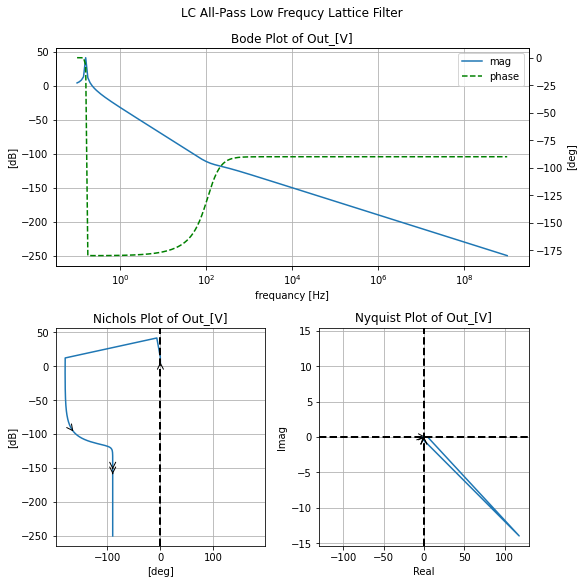

In [124]:
filter_responce=qfilter_explorer(circ, 'LC All-Pass Low Frequcy Lattice Filter');

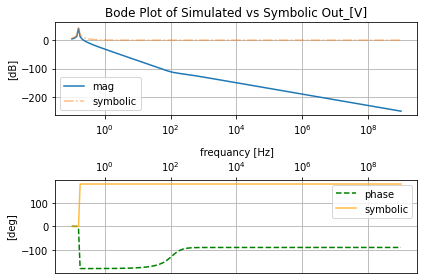

In [125]:
filter_responce.symbolic_tf(allpasslat_lf)

The reason it's diverging and more specifically flipped in phase might be due to how lcapy is treating the `0` as ground when it formulates the modified nodal analysis. As seen below with the lack of a `V_3` term. Going to pass on fixing this right now but it is top of the TODO list for this section

In [126]:
allpasslat_lf.lcapy_self(False, False)
n=kiwi.NodalAnalysis(allpasslat_lf.schematic.laplace())
n.nodal_equations()

⎧                  V₁ - V₃                           V₂                  -V₁ +
⎪1: C₁⋅(V₁ - V₂) + ─────── = 0, 2: C₁⋅(-V₁ + V₂) + ───── = 0, 3: C₂⋅V₃ + ─────
⎨                       2                              2                      
⎪                   L₂⋅s                           L₁⋅s                   L₂⋅s
⎩                                                                             

 V₃    ⎫
─── = 0⎪
2      ⎬
       ⎪
       ⎭

## Citations:

[1] ALL ABOUT ELECTRONICS. "RC Low Pass Filter Explained," YouTube, Aug 20, 2017. [Video file]. Available: https://youtu.be/_2L0l-E1Wx0. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "RC High Pass Filter Explained," YouTube, Aug 23, 2017. [Video file]. Available: https://youtu.be/9Dx0b0ukNAM. [Accessed: Nov 30, 2020].

[3] ALL ABOUT ELECTRONICS. "Band Pass Filter and Band Stop Filter Explained," YouTube, Sep 2, 2017. [Video file]. Available: https://youtu.be/dmPIydL0lyM. [Accessed: Nov 30, 2020].

[4] S. Makarov, R. Ludwig and S. Bitar, Practical electrical engineering. Cham: Springer International Publishing, 2016, pp. 514-515.

[5] "Lattice phase equaliser", En.wikipedia.org, 2021. [Online]. Available: https://en.wikipedia.org/wiki/Lattice_phase_equaliser. [Accessed: 10- Jan- 2021]. 

[6] "Lattice network", En.wikipedia.org, 2021. [Online]. Available: https://en.wikipedia.org/wiki/Lattice_network. [Accessed: 10- Jan- 2021]. 

